In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
import statistics
import seaborn as sns
from os import walk
import math
from scipy import stats
from matplotlib import rcParams

palette ={"CRC":"grey",'Japanese':'gold'}

## Load Bacterial Relative Abundance DataFrames for all Countries

In [2]:
#Strain Dataframes
CRCStrains = pd.read_csv('./Files/Dataframes/strainDataframes/masterCRC_allStrains.csv').set_index("SampleName")
japaneseStrains = pd.read_csv('./Files/Dataframes/strainDataframes/masterJapanese_allStrains.csv').set_index("SampleName")

CRCStrains_RAc  = CRCStrains.copy()
CRCStrains_RAc['Cohort']='CRC'
japaneseStrains_RAc = japaneseStrains.copy()
japaneseStrains_RAc['Cohort']='Healthy'

In [3]:
######################################################################################

In [4]:
BothCohortAllSpecies = pd.read_csv('./Files/Dataframes/allCohorts_allSpecies.csv').set_index("SampleName")
BothCohortSharedSpecies = pd.read_csv('./Files/GGM/RFC_DA_Run/RFC_DA_SpeciesAbundance.csv').set_index("SampleName")

In [5]:
#Shared Species with original relative abundances (not Normalized)
CRCUnionSpecies = BothCohortAllSpecies[BothCohortAllSpecies['Cohort']=='CRC'][list(BothCohortSharedSpecies.columns)].drop(columns=['Cohort']).copy()
HealthyUnionSpecies = BothCohortAllSpecies[BothCohortAllSpecies['Cohort']=='Healthy'][list(BothCohortSharedSpecies.columns)].drop(columns=['Cohort']).copy()

CRCSharedSpecies_RAc  = CRCUnionSpecies.copy()
CRCSharedSpecies_RAc['Cohort']='CRC'
HealthySharedSpecies_RAc = HealthyUnionSpecies.copy()
HealthySharedSpecies_RAc['Cohort']='Healthy'

In [6]:
################################################################

## Read in Global DF - All Cohorts

In [ ]:
globalAbundanceDFSpecies  = pd.read_csv('./Files/Dataframes/allCohorts_allSpecies.csv').set_index("SampleName")
globalAbundanceDFSpecies90  = pd.read_csv('./Files/Dataframes/allCohorts_90Prev_Species.csv').set_index("SampleName")
globalAbundanceDFGenus = pd.read_csv('./Files/Dataframes/allCohorts_allGenera.csv').set_index("SampleName")

## Grab all Genome Lengths for strains, Average them for species genome length, average that for genus length

In [ ]:
BacterialPhylums = {"Unclassified_Bacteria":"Unknown", "Acidobacteria":'Gram_Negative',"Actinobacteria":'Gram_Positive',"Aquificae":'Gram_Negative',"Armatimonadetes":'Gram_Negative',"Bacteroidetes":'Gram_Negative',"Balneolaeota":'Unknown',"Caldiserica":"Unknown","Calditrichaeota":"Unknown","Chlamydiae":'Gram_Negative',"Chlorobi":"Unknown","Chloroflexi":"Unknown","Chrysiogenetes":"Unknown","Coprothermobacterota":"Unknown","Cyanobacteria":"Unknown","Deferribacteres":"Gram_Negative","Deinococcus-Thermus":"Gram_Negative","Dictyoglomi":"Gram_Negative","Elusimicrobia":"Unknown","Fibrobacteres":"Unknown","Firmicutes":"Gram_Positive","Fusobacteria":"Gram_Negative","Gemmatimonadetes":"Gram_Negative","Kiritimatiellaeota":"Unkown","Lentisphaerae":"Unknown","Nitrospirae":"Unknown","Planctomycetes":"Unknown","Proteobacteria":"Gram_Negative","Rhodothermaeota":"Unknown","Spirochaetes":"Gram_Negative","Synergistetes":"Gram_Negative","Tenericutes":"Unknown","Thermodesulfobacteria":"Unknown","Thermotogae":"Gram_Negative","Verrucomicrobia":"Unknown"}

In [ ]:
accTaxDictDF = pd.read_csv("./Files/Dataframes/Master_Rename.csv").set_index("Bacterial_Strain")
accTaxDictDF['Species'] = accTaxDictDF['Species'].astype(str)
accTaxDictDF.head()

accTaxDictDF2 = accTaxDictDF.reset_index().set_index("Species").copy()

accTaxDictDF3 = accTaxDictDF2.loc[~accTaxDictDF2.index.duplicated(keep='first')].copy()

In [ ]:
generaFindDF = accTaxDictDF.reset_index().set_index("Species").copy()
generaFindDF_master = generaFindDF.loc[~generaFindDF.index.duplicated(keep='first')].copy()

## Pull Partial Correlations

In [ ]:
#Takes in the partial correlation matrix pulls top triangle and returns associations that are not 0 or -1
def allAssociations(df):
    df2 = df.copy()
    df3 = df2.drop(columns=['Unnamed: 0']).copy()
    indexRename = {}
    count = 0
    
    for column in df3.columns:
        indexRename[count] = column
        count+=1
        
    df3.rename(index=indexRename, inplace=True)

    df4 = df3.where(np.triu(np.ones(df3.shape)).astype(np.bool))
    df4 = df4.stack().reset_index()
    df4.columns = ['Node1','Node2','Association_Weight']
    
    for i in df4.index:
        if df4.at[i,'Association_Weight'] == -1.0:
            df4.drop(index=i, inplace=True)
            
    return(df4)

In [ ]:
def collapseToSpecies(dictionary):
    newDictionary = {}
    tempDic = {"Bacteria":[], "Length":[]}
    for k,v in dictionary.items():
        if '_sp_' in k:
            tempDic['Bacteria'].append('_'.join(k.split("_")[:3]).strip())
            tempDic['Length'].append(v)
        else:
            tempDic['Bacteria'].append('_'.join(k.split("_")[:2]).strip())
            tempDic['Length'].append(v)
            
    tempDF = pd.DataFrame(data=tempDic).set_index("Bacteria").T
    tempDF2 = tempDF.groupby(lambda x:x, axis=1).mean().copy()
    
    for row in tempDF2.index:
        for column in tempDF2.columns:
            newDictionary[column] = tempDF2.at[row,column]
            
    return newDictionary

In [ ]:
def collapseToGenus(dictionary):
    newDictionary = {}
    tempDic = {"Bacteria":[], "Length":[]}
    for k,v in dictionary.items():
        tempDic['Bacteria'].append(k.split("_")[0].strip())
        tempDic['Length'].append(v)
            
    tempDF = pd.DataFrame(data=tempDic).set_index("Bacteria").T
    tempDF2 = tempDF.groupby(lambda x:x, axis=1).mean().copy()
    
    for row in tempDF2.index:
        for column in tempDF2.columns:
            newDictionary[column] = tempDF2.at[row,column]
            
    return newDictionary

In [ ]:
#Grab Bacterial Reference Strain Genome Lengths
for (dirpath, dirnames, filenames) in walk('./Files/bacterialInformation/'):
    f= open("./Files/bacterialInformation/"+filenames[1],"r+")
    next(f)
    strainDic = {}
    for line in f:
        if 'PLASMID' in line.split("\t")[0].strip():
            continue
        else:
            strainDic[line.split("\t")[0].strip()] = int(line.split("\t")[1].strip())
strainDic

In [ ]:
crcStrainDic = {k: strainDic[k] for k in CRCStrains.columns}
japaneseStrainDic = {k: strainDic[k] for k in japaneseStrains.columns}

## Build Networks

In [ ]:
#Takes in the partial correlation matrix pulls top triangle and returns associations that are not -1
def allAssociations(df):
    df2 = df.copy()
    df3 = df2.drop(columns=['Unnamed: 0']).copy()
    indexRename = {}
    count = 0
    
    for column in df3.columns:
        indexRename[count] = column
        count+=1
        
    df3.rename(index=indexRename, inplace=True)

    df4 = df3.where(np.triu(np.ones(df3.shape)).astype(np.bool))
    df4 = df4.stack().reset_index()
    df4.columns = ['Node1','Node2','Association_Weight']
    
    for i in df4.index:
        if df4.at[i,'Association_Weight'] == -1.0:
            df4.drop(index=i, inplace=True)
            
    return(df4)

In [ ]:
import networkx as nx
import numpy as np
from scipy import integrate

def createSparseGrowthNetworkSpecies(partialdf, abundanceDF):
    G = nx.Graph()
       
    for node in list(set(list(partialdf['Node1']) + list(partialdf['Node2']))):
        G.add_node(node.replace(".","-").strip(), relativeAbundance=abundanceDF[node.replace(".","-").strip()].mean(), genera=generaFindDF_master.at[node.replace(".","-").strip(), 'Genus'].strip())
    
    for row in partialdf.index:
        if abs(partialdf.at[row, 'Association_Weight']) > 0.01:
            G.add_edge(partialdf.at[row, 'Node1'].replace(".","-").strip(),partialdf.at[row,'Node2'].replace(".","-").strip(), weight=partialdf.at[row, "Association_Weight"])
        else:
            continue
        
    return G;

In [ ]:
################################## LOAD PARTIALS ####################################################

In [ ]:
#Read in partial correlations between species
crcPCor = allAssociations(pd.read_csv('./Files/GGM/RFC_DA_Run/Partials/crc_partial.csv'))
HealthyPCor = allAssociations(pd.read_csv('./Files/GGM/RFC_DA_Run/Partials/healthy_partial.csv'))

In [ ]:
#################################### BUILD NETWORKS #######################################################

In [ ]:
#Disparity Networks
crcNetwork = createSparseGrowthNetworkSpecies(crcPCor, CRCUnionSpecies)
healthyNetwork = createSparseGrowthNetworkSpecies(HealthyPCor, HealthyUnionSpecies)

## View Distribution of Association Strengths 

In [ ]:
def pullAssociationDistribution(network, cohortname):
    tempDict = {'Association_Weight':[], 'Cohort':[]}
    for i in network.edges:
        tempDict['Association_Weight'].append(network.edges[i]['weight'])
        tempDict['Cohort'].append(cohortname)
    pdDF = pd.DataFrame(data=tempDict)
    return(pdDF)

In [ ]:
#Shared Species
crcSharedSpeciesASS = pullAssociationDistribution(crcNetwork, 'CRC')
japaneseSharedSpeciesASS = pullAssociationDistribution(healthyNetwork, 'Healthy')

#Combine all into one dataframe
associationSharedSpecies = pd.concat([japaneseSharedSpeciesASS[['Association_Weight','Cohort']], crcSharedSpeciesASS[['Association_Weight','Cohort']]])

In [ ]:
palette ={"CRC":"grey",'Healthy':'gold'}

rcParams['figure.figsize'] = 11.7,8.27
ax = sns.violinplot(x="Cohort", y="Association_Weight", data=associationSharedSpecies, palette=palette)
ax = sns.swarmplot(x="Cohort", y="Association_Weight", data=associationSharedSpecies, color="black")

testList = []
for x in list(ax.get_xticklabels()):
    testList.append(str(str(x.get_text())+"\n"+"(n="+str(len(associationSharedSpecies[associationSharedSpecies['Cohort']==str(x.get_text())]))+")"))
ax.set_xticklabels(testList)

sns.set(font_scale=1.3)
ax.set_xlabel('Network',labelpad=15)
ax.set_ylabel('Association Weight', labelpad=15)
ax.set_title('Group Network Association Weight Distributions', pad=10)
#plt.savefig("species_networkAssociationWeights_shared.pdf", bbox_inches='tight', dpi=300)
plt.show()

## Find out what Associations are shared

In [ ]:
def compareAllEdges(network1, network2, listt):
    
    columnNames = listt
    allEdges_Refined = []
    
    for (u, v, c) in network1.edges.data():
        tempList = sorted([u,v])
        if str(tempList[0]+"<-->"+tempList[1]) in allEdges_Refined:
            continue
        else:
            allEdges_Refined.append(str(tempList[0]+"<-->"+tempList[1]))
            
    for (u, v, c) in network2.edges.data():
        tempList = sorted([u,v])
        if str(tempList[0]+"<-->"+tempList[1]) in allEdges_Refined:
            continue
        else:
            allEdges_Refined.append(str(tempList[0]+"<-->"+tempList[1]))
            
            
    #Create a dataframe with all edges and see how many are found in each network
    allNodesDF = pd.DataFrame(index=allEdges_Refined, columns=columnNames)
    #allNodesDF.fillna(0, inplace=True)
    
    for (u, v, c) in network1.edges.data():
        tempList = sorted([u,v])
        allNodesDF.at[tempList[0]+"<-->"+tempList[1], 'Healthy'] = float(c['weight'])
        
    for (u, v, c) in network2.edges.data():
        tempList = sorted([u,v])
        allNodesDF.at[tempList[0]+"<-->"+tempList[1], 'CRC'] = float(c['weight'])
    
    
    df2 = allNodesDF.copy()
    return(df2)

In [ ]:
def pullEdgeStatsPercentage(df):
    
    df2 = df.copy()
    
    tempDict = {"Network":[], "Total_Associations":[], "Unique_Associations":[], "Shared_Associations":[]}

    for column in df2.columns:
        tempDict['Network'].append(column)
        tempDict['Total_Associations'].append(len(df2[column].dropna()))
        
        rows = list(df2[column].dropna().index)
        
        tempDict['Unique_Associations'].append(int(len(df2.loc[rows])-len(df2.loc[rows].dropna(axis=0, thresh=2))) / len(df2[column].dropna()))
        tempDict['Shared_Associations'].append(int(len(df2.loc[rows].dropna(axis=0, thresh=2))) / len(df2[column].dropna()))
    
    tempdf = pd.DataFrame(data=tempDict).set_index("Network")
    
    return(tempdf)

In [ ]:
compDF = compareAllEdges(healthyNetwork,crcNetwork,['Healthy','CRC'])

EdgeStatsDF = pullEdgeStatsPercentage(compDF)
EdgeStatsDF2 = EdgeStatsDF.copy()
EdgeStatsDF2.reset_index(inplace=True)
EdgeStatsDF2.drop(columns=['Total_Associations'], inplace=True)

In [ ]:
# This is all previously recorded bacterial associations occurring within healthy gut microbiomes
compDF_all = pd.read_csv("./Files/allAssociations.csv").set_index("Unnamed: 0")
compDF_all.head()

In [ ]:
# Find only associations in healthy network

In [ ]:
compDF2 = compDF.copy()
compDF2.fillna('None', inplace=True)

In [ ]:
HealthyOnly = []
for row in compDF2.index:
    try:
        if abs(compDF2.at[row,'Healthy']) > 0.0:
            if compDF2.at[row,'CRC'] == 'None':
                HealthyOnly.append(row)
    except:
        continue
        #print(compDF2.at[row,'Healthy'])

## Look at association statistics

In [ ]:
EdgeStatsDF2.rename(columns={'Unique_Associations':"Unique Associations",'Shared_Associations':"Shared Associations"}, inplace=True)

In [ ]:
EdgeStatsDF3 = EdgeStatsDF2.set_index("Network").copy()

In [ ]:
EdgeStatsDF2

In [ ]:
EdgeStatsDF2.plot(kind='bar', stacked=True, x='Network', color=['gold','black'])
plt.ylabel("Proportion of Total Associations")
plt.xlabel("Group Network")
plt.title("Group Network Association Diversity", pad=45)
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 11,8.27
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.09),
          fancybox=True, ncol=2)
plt.xticks(rotation=0)

#plt.savefig("SharedSpecies_AssociationsPercentages.pdf", bbox_inches='tight', dpi=300)
#plt.savefig("SharedSpecies_AssociationsPercentages.svg", bbox_inches='tight', dpi=300)
plt.show()

## What edges are only in CRC?

In [ ]:
healthyEdgeDF = compDF[['Healthy']].dropna().copy()
crcEdgeDF = compDF[['CRC']].dropna().copy()
crcEdgeDF_drop = crcEdgeDF.copy()

In [ ]:
sharedEdges=[]
for edge in crcEdgeDF.index:
    if edge in healthyEdgeDF.index:
        sharedEdges.append(edge)
print(len(sharedEdges))
crcEdgeDF_drop.drop(index=sharedEdges,inplace=True)

In [ ]:
#Now see what edges left are found in cohorts previously
sharedAllCohortEdges=[]
for edge in crcEdgeDF_drop.index:
    if edge in compDF_all.index:
        sharedAllCohortEdges.append(edge)
print(len(sharedAllCohortEdges))
crcEdgeDF_trimmed = crcEdgeDF_drop.drop(index=sharedAllCohortEdges).copy()

In [ ]:
speciesList_raw = []
generaList_raw = []

for i in crcEdgeDF_trimmed.index:
    speciesList_raw.append(i.split("<-->")[0])
    speciesList_raw.append(i.split("<-->")[1])
    
    generaList_raw.append(accTaxDictDF3.at[i.split("<-->")[0].replace(".","-"), 'Genus'])
    generaList_raw.append(accTaxDictDF3.at[i.split("<-->")[1].replace(".","-"), 'Genus'])
    
    
speciesList = list(set(speciesList_raw.copy()))
generaList = list(set(generaList_raw.copy()))

speciesCRC_df = pd.DataFrame(index=sorted(speciesList), columns=sorted(speciesList)).fillna(int(0))
generaCRC_df = pd.DataFrame(index=sorted(generaList), columns=sorted(generaList)).fillna(int(0))

In [ ]:
for i in crcEdgeDF_trimmed.index:
    speciesCRC_df.at[str(i.split("<-->")[0]), str(i.split("<-->")[1])] += 1
    generaCRC_df.at[accTaxDictDF3.at[i.split("<-->")[0].replace(".","-"), 'Genus'], accTaxDictDF3.at[i.split("<-->")[1].replace(".","-"), 'Genus']] += 1

In [ ]:
plt.subplots(figsize=(15,15))
sns.heatmap(generaCRC_df, cmap="YlGnBu", annot=False, xticklabels=1, yticklabels=1, linewidths=.1)

## Look at edges more closely

In [ ]:
#Find Species with no Edges in both networks
noEdgeCRC = [node for (node, val) in crcNetwork.degree() if val == 0]
noEdgeHealthy = [node for (node, val) in healthyNetwork.degree() if val == 0]

bothNoEdge = []
for species in noEdgeHealthy:
    if species in noEdgeCRC:
        bothNoEdge.append(species)
        
bothNoEdge

In [ ]:
moduelClusterDF = pd.read_csv("./Files/Networks/Modules/ModuleCluster_df.csv").set_index("Module")
moduleCluster_dict = {}
for row in moduelClusterDF.index:
    for column in moduelClusterDF.columns:
        if moduelClusterDF.at[row,column] == 1.0:
            moduleCluster_dict[row] = column
        else:
            continue
            
import dill
import pickle

with open('./Files/Networks/Modules/Healthy_modules.pkl', 'rb') as handle:
    healthyModuleLabel = pickle.load(handle)
    
    
with open('./Files/Networks/Modules/CRC_modules.pkl', 'rb') as handle:
    crcModuleLabel = pickle.load(handle)
    
crcNodeClusterColor = {}
for module in crcModuleLabel.keys():
    for species in crcModuleLabel[module]:
        crcNodeClusterColor[species]=moduleCluster_dict[module]
        
healthyNodeClusterColor = {}
for module in healthyModuleLabel.keys():
    for species in healthyModuleLabel[module]:
        healthyNodeClusterColor[species]=moduleCluster_dict[module]

In [ ]:
# Make a list of shared edges
tempList = []
for edge in compDF.dropna().index:
    tempList.append(str(edge.split("<-->")[0])+","+str(edge.split("<-->")[1]))
print(len(tempList))

In [ ]:
healthyNetwork2 = healthyNetwork.copy()
crcNetwork2 = crcNetwork.copy()
sharedNetwork = healthyNetwork.copy()
for x in list(healthyNetwork.edges(data=True)):
    if str(x[0])+","+str(x[1]) in tempList or str(x[1])+","+str(x[0]) in tempList:
        crcNetwork2.remove_edge(x[0],x[1])
        healthyNetwork2.remove_edge(x[0],x[1])
        continue
    else:
        sharedNetwork.remove_edge(x[0],x[1])


crcEdgeColorList = []
for x in list(crcNetwork.edges(data=True)):
    if str(x[0])+","+str(x[1]) in tempList or str(x[1])+","+str(x[0]) in tempList:
        crcEdgeColorList.append('black')
    else:
        if float(x[2]['weight']) > 0:
            crcEdgeColorList.append('#3eb56d')
        else:
            crcEdgeColorList.append('red')

healthyEdgeColorList = []
for x in list(healthyNetwork.edges(data=True)):
    if str(x[0])+","+str(x[1]) in tempList or str(x[1])+","+str(x[0]) in tempList:
        healthyEdgeColorList.append('black')
    else:
        if float(x[2]['weight']) > 0:
            healthyEdgeColorList.append('#3eb56d')
        else:
            healthyEdgeColorList.append('red')
            
            
            
crcEdgeColorList2 = []
healthyEdgeColorList2 = []
for x in list(crcNetwork2.edges(data=True)):
    if float(x[2]['weight']) > 0:
        crcEdgeColorList2.append('#3eb56d')
    else:
        crcEdgeColorList2.append('red')
            
for x in list(healthyNetwork2.edges(data=True)):
    if float(x[2]['weight']) > 0:
        healthyEdgeColorList2.append('#3eb56d')
    else:
        healthyEdgeColorList2.append('red')

In [ ]:
nodeList2 = [species for species in crcNetwork.nodes if species not in bothNoEdge]

accTaxDictDF3.at['bacterium_LF-3','Phylum'] = "Firmicutes"

nodeTaxDF = accTaxDictDF3[["Phylum","Class","Order","Family","Genus"]].copy()

nodeList3 = list(nodeTaxDF.loc[nodeList2].sort_values(by=['Phylum','Class','Order','Family','Genus'],ascending=True).index)

In [ ]:
# USE THIS FOR NODE SIDE = TO THE DEGREE
crcNodeSize = []
healthyNodeSize = []
for i in nodeList3:
    crcNodeSize.append(float(crcNetwork.degree(i)+1)*5)
    healthyNodeSize.append(float(healthyNetwork.degree(i)+1)*5)

In [ ]:
print(len(nodeList3))

In [ ]:
with open("/home/mark/Desktop/AllNodes.txt", 'a+') as f:
    for i in nodeList3:
        f.write(i+", ")
    f.close()

In [ ]:
HealthynodeColor = {}

for i in nodeList3:
    if i in list(healthyNodeClusterColor.keys()):
        if healthyNodeClusterColor[i] == 'Cluster_1':
            HealthynodeColor[i]="#023eff"
        elif healthyNodeClusterColor[i] =='Cluster_2':
            HealthynodeColor[i]="#ff7c00"
        elif healthyNodeClusterColor[i] =='Cluster_3':
            HealthynodeColor[i]="#1ac938"
        elif healthyNodeClusterColor[i] =='Cluster_4':
            HealthynodeColor[i]="#8b2be2"
        elif healthyNodeClusterColor[i] =='Cluster_5':
            HealthynodeColor[i]="#e8000b"
    else:
        HealthynodeColor[i]="grey"

In [ ]:
CRCnodeColor = {}
for i in nodeList3:
    if i in list(crcNodeClusterColor.keys()):
        if crcNodeClusterColor[i] == 'Cluster_1':
            CRCnodeColor[i]="#023eff"
        elif crcNodeClusterColor[i] == 'Cluster_2':
            CRCnodeColor[i]="#ff7c00"
        elif crcNodeClusterColor[i] == 'Cluster_3':
            CRCnodeColor[i]="#1ac938"
        elif crcNodeClusterColor[i] == 'Cluster_4':
            CRCnodeColor[i]="#8b2be2"
        elif crcNodeClusterColor[i] == 'Cluster_5':
            CRCnodeColor[i]="#e8000b"
    else:
        CRCnodeColor[i]="grey"

In [ ]:
len(CRCnodeColor)

In [ ]:
greyList =[]
for x,y in CRCnodeColor.items():
    if y =='grey':
        greyList.append(x)

In [ ]:
for i in greyList:
    if i in crcNodeClusterColor.keys():
        print(i)
        print(crcNodeClusterColor[i])
        print("\n")

In [ ]:
ClusterColorlegend = {"Cluster_1":"#023eff","Cluster_2":"#ff7c00","Cluster_3":"#1ac938","Cluster_4":"#8b2be2","Cluster_5":"#e8000b"}

In [ ]:
def get_key(val, dictt): 
    for key, value in dictt.items(): 
        if val == value: 
            return key 

In [ ]:
#What percentage of species falls within each cluster or no cluster
from collections import Counter
tempDict = {'Group':[], 'Cluster_1':[], 'Cluster_2':[], 'Cluster_3':[], 'Cluster_4':[], 'Cluster_5':[], 'None':[]}

tempDict['Group'].append("Healthy")
healthyCount = Counter(list(HealthynodeColor.values()))
for x,y in healthyCount.items():
    tempDict[str(get_key(x,ClusterColorlegend))].append(y/(len(list(HealthynodeColor.values()))))
    
tempDict['Group'].append("CRC")
CRCcount = Counter(list(CRCnodeColor.values()))
for x,y in CRCcount.items():
    tempDict[str(get_key(x,ClusterColorlegend))].append(y/(len(list(CRCnodeColor.values()))))

tempDF_clusterPercentage = pd.DataFrame(data=tempDict).set_index("Group")
tempDF_clusterPercentage

In [ ]:
sharednodeColor = {}
for i in nodeList3:
    if nodeTaxDF.loc[i]['Phylum'] == 'Actinobacteria':
        sharednodeColor[i]="#db57ff"
    elif nodeTaxDF.loc[i]['Phylum'] =='Bacteroidetes':
        sharednodeColor[i]="#24e0b8"
    elif nodeTaxDF.loc[i]['Phylum'] =='Firmicutes':
        sharednodeColor[i]="#ffcc51"
    elif nodeTaxDF.loc[i]['Phylum'] =='Proteobacteria':
        sharednodeColor[i]="#ff3031"
    else:
        sharednodeColor[i]="#ff3031"

In [ ]:
Phylumlegend = {"Actinobacteria":"#db57ff","Bacteroidetes":"#24e0b8","Firmicutes":"#ffcc51","Proteobacteria":"#ff3031"}

In [ ]:
from matplotlib.lines import Line2D
rcParams["legend.fancybox"] = True
fig, ax = plt.subplots(1, 3, num=1, figsize=(30,9))

posit = nx.circular_layout(nodeList3)

nx.draw_networkx_nodes(sharedNetwork, pos=posit, nodelist=nodeList3, node_size=15, with_labels=False, node_color=list(sharednodeColor.values()), ax=ax[0])
nx.draw_networkx_edges(sharedNetwork, pos=posit, width=.2, edge_color='#3eb56d', ax=ax[0])
ax[0].set_title("Shared Associations Network", fontsize=22)
ax[0].set_facecolor('white')
ax[0].set_axis_off()
fig.set_facecolor('white')

lines2 = [Line2D([0], [0], marker='o', color='white', markerfacecolor=Phylumlegend[c], linewidth=20) for c in list(Phylumlegend.keys())]
labels2 = list(Phylumlegend.keys())
newLeg = plt.legend(lines2, labels2, bbox_to_anchor=(-1.73, -.05), prop={'size': 18}, loc=0, borderaxespad=0, title='Node Phylum', facecolor='w',edgecolor='white')

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.1, -0.15), 0.28, 1.19, fill=False, color="k", lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])


nx.draw_networkx_nodes(healthyNetwork2, pos=posit, nodelist=nodeList3, node_size=healthyNodeSize, with_labels=False, node_color=list(HealthynodeColor.values()), font_size=10, ax=ax[1])
nx.draw_networkx_edges(healthyNetwork2, pos=posit, width=.2, edge_color=healthyEdgeColorList2, ax=ax[1])
ax[1].set_title("Healthy Network (Unique Associations)", fontsize=22)
ax[1].set_facecolor('white')
ax[1].set_axis_off()
fig.set_facecolor('white')

nx.draw_networkx_nodes(crcNetwork2, pos=posit, nodelist=nodeList3, node_size=crcNodeSize, with_labels=False, node_color=list(CRCnodeColor.values()), font_size=10, ax=ax[2])
nx.draw_networkx_edges(crcNetwork2, pos=posit, width=.2, edge_color=crcEdgeColorList2, ax=ax[2])
ax[2].set_title("CRC Network (Unique Associations)", fontsize=22)
ax[2].set_facecolor('white')
ax[2].set_axis_off()
fig.set_facecolor('white')

lines3 = [Line2D([0], [0], marker='o', color='white', markerfacecolor=ClusterColorlegend[c], linewidth=3) for c in list(ClusterColorlegend.keys())]
labels3 = list(ClusterColorlegend.keys())
labels4 = labels3.copy()
label5 = []
for label in labels4:
    label5.append(str(label.split("_")[0])+": "+str(label.split("_")[1]))
    
firstLeg = plt.legend(lines3, label5, bbox_to_anchor=(-.25, -.01), prop={'size': 18}, fancybox=True, loc=2, borderaxespad=0, title='Node Cluster', facecolor='w', edgecolor='white')
plt.gca().add_artist(newLeg)
plt.setp(newLeg.get_title(),fontsize='large')
plt.setp(firstLeg.get_title(),fontsize='large')

#plt.savefig("sharedNetwork3Panel.pdf", bbox_inches='tight', dpi=300)
#plt.savefig("sharedNetwork3Panel.png", bbox_inches='tight', dpi=300)

plt.show()

## Look at cluster relative abundance

In [ ]:
crcGrey = []
healthyGrey = []
for x,y in CRCnodeColor.items():
    if y == 'grey':
        crcGrey.append(x)

for x,y in HealthynodeColor.items():
    if y == 'grey':
        healthyGrey.append(x)

In [ ]:
healthySpeciesDF = BothCohortAllSpecies[BothCohortAllSpecies['Cohort']=='Healthy'].drop(columns=['Cohort']).copy()
crcSpeciesDF = BothCohortAllSpecies[BothCohortAllSpecies['Cohort']=='CRC'].drop(columns=['Cohort']).copy()

In [ ]:
def pullClusterAbundance(dictt, greyList, speciesDF, groupName):
    dict2 = dictt.copy()
    cluster1 = []
    cluster2 = []
    cluster3 = []
    cluster4 = []
    cluster5 = []
    noCluster = greyList.copy()
    
    for x,y in dict2.items():
        if y == 'Cluster_1':
            cluster1.append(x)
        elif y == 'Cluster_2':
            cluster2.append(x)
        elif y == 'Cluster_3':
            cluster3.append(x)
        elif y == 'Cluster_4':
            cluster4.append(x)
        elif y == 'Cluster_5':
            cluster5.append(x)
        else:
            continue
    
    tempDict = {"SampleName":[], "Group":[], "Cluster":[], "Total_Relative_Abundance":[]}
    
    for sample in speciesDF.index:
        tempDict['SampleName'].append(sample)
        tempDict['Group'].append(groupName)
        tempDict['Cluster'].append('Cluster 1')
        tempDict['Total_Relative_Abundance'].append(speciesDF[cluster1].loc[sample].sum())
        
        tempDict['SampleName'].append(sample)
        tempDict['Group'].append(groupName)
        tempDict['Cluster'].append('Cluster 2')
        tempDict['Total_Relative_Abundance'].append(speciesDF[cluster2].loc[sample].sum())
        
        tempDict['SampleName'].append(sample)
        tempDict['Group'].append(groupName)
        tempDict['Cluster'].append('Cluster 3')
        tempDict['Total_Relative_Abundance'].append(speciesDF[cluster3].loc[sample].sum())
        
        tempDict['SampleName'].append(sample)
        tempDict['Group'].append(groupName)
        tempDict['Cluster'].append('Cluster 4')
        tempDict['Total_Relative_Abundance'].append(speciesDF[cluster4].loc[sample].sum())
        
        tempDict['SampleName'].append(sample)
        tempDict['Group'].append(groupName)
        tempDict['Cluster'].append('Cluster 5')
        tempDict['Total_Relative_Abundance'].append(speciesDF[cluster5].loc[sample].sum())
        
        tempDict['SampleName'].append(sample)
        tempDict['Group'].append(groupName)
        tempDict['Cluster'].append('No Cluster')
        tempDict['Total_Relative_Abundance'].append(speciesDF[noCluster].loc[sample].sum())


    tempDF = pd.DataFrame(data=tempDict)
    return(tempDF.set_index("SampleName"))

In [ ]:
crcClustAbun = pullClusterAbundance(crcNodeClusterColor, crcGrey, crcSpeciesDF, "CRC")
healthyClustAbun = pullClusterAbundance(healthyNodeClusterColor, healthyGrey, healthySpeciesDF, "Healthy")

In [ ]:
bothGroupClust = pd.concat([healthyClustAbun,crcClustAbun])

In [ ]:
# Test for statistical significance Mann-Whitney U Test
from statsmodels.stats.multitest import multipletests
import scipy
from scipy import stats
import os
import statistics
import statsmodels
import statsmodels.api as sm 
import random

In [ ]:
plt.subplots(figsize=(20,7))
palette ={"CRC":"grey",'Healthy':'gold'}
ax = sns.boxplot(x="Cluster", y="Total_Relative_Abundance", data=bothGroupClust, hue='Group', palette=palette)
ax.legend(facecolor='white', title='Group')

sns.set(font_scale=1.5)
ax.set_xlabel('Cluster',labelpad=15)
ax.set_ylabel('Total Sample Relative Abundance', labelpad=15)
plt.ylim((0,1))


x1, x2 = -0.2, 0.2
y, h, col = 0.5, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

x1, x2 = 0.8, 1.2
y, h, col = 0.15, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

x1, x2 = 1.8, 2.2
y, h, col = 0.35, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

x1, x2 = 2.8, 3.2
y, h, col = 0.90, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

x1, x2 = 3.8, 4.2
y, h, col = 0.80, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

x1, x2 = 4.8, 5.2
y, h, col = 0.60, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

plt.savefig("clusterTotalAbundance.pdf", bbox_inches='tight', dpi=300)

In [ ]:
(test_statistic, p_value) = stats.mannwhitneyu(list(healthyClustAbun[healthyClustAbun['Cluster']=='Cluster 1']['Total_Relative_Abundance']),list(crcClustAbun[crcClustAbun['Cluster']=='Cluster 1']['Total_Relative_Abundance']), alternative="two-sided") 
p_value

In [ ]:
(test_statistic, p_value) = stats.mannwhitneyu(list(healthyClustAbun[healthyClustAbun['Cluster']=='Cluster 2']['Total_Relative_Abundance']),list(crcClustAbun[crcClustAbun['Cluster']=='Cluster 2']['Total_Relative_Abundance']), alternative="two-sided") 
p_value

In [ ]:
(test_statistic, p_value) = stats.mannwhitneyu(list(healthyClustAbun[healthyClustAbun['Cluster']=='Cluster 3']['Total_Relative_Abundance']),list(crcClustAbun[crcClustAbun['Cluster']=='Cluster 3']['Total_Relative_Abundance']), alternative="two-sided") 
p_value

In [ ]:
(test_statistic, p_value) = stats.mannwhitneyu(list(healthyClustAbun[healthyClustAbun['Cluster']=='Cluster 4']['Total_Relative_Abundance']),list(crcClustAbun[crcClustAbun['Cluster']=='Cluster 4']['Total_Relative_Abundance']), alternative="two-sided") 
p_value

In [ ]:
(test_statistic, p_value) = stats.mannwhitneyu(list(healthyClustAbun[healthyClustAbun['Cluster']=='Cluster 5']['Total_Relative_Abundance']),list(crcClustAbun[crcClustAbun['Cluster']=='Cluster 5']['Total_Relative_Abundance']), alternative="two-sided") 
p_value

In [ ]:
(test_statistic, p_value) = stats.mannwhitneyu(list(healthyClustAbun[healthyClustAbun['Cluster']=='No Cluster']['Total_Relative_Abundance']),list(crcClustAbun[crcClustAbun['Cluster']=='No Cluster']['Total_Relative_Abundance']), alternative="two-sided") 
p_value

## Only Visualize Shared portions

In [ ]:
compDF.dropna().head(10)
sharedCRC = crcNetwork.copy()
sharedHealhty = healthyNetwork.copy()

In [ ]:
for i in sharedCRC.edges():
    if str(i[0])+","+str(i[1]) in tempList or str(i[1])+","+str(i[0]) in tempList:
        continue
    else:
        sharedCRC.remove_edge(i[0],i[1])

In [ ]:
sharedCRC2 = sharedCRC.copy()

In [ ]:
sharedCRC2.remove_nodes_from(nx.isolates(sharedCRC))

In [ ]:
nx.draw(sharedCRC2)

## Visualize Important Species

In [ ]:
RFC_speciesList = ['Peptostreptococcus_stomatis','Parvimonas_micra','Fusobacterium_nucleatum','Gemella_morbillorum','Dialister_pneumosintes''Peptostreptococus_anaerobius']

In [ ]:
netCRC_RFC = crcNetwork.copy()
netHealthy_RFC = healthyNetwork.copy()

In [ ]:
for i in crcNetwork.edges():
    if  i[0] in RFC_speciesList or i[1] in RFC_speciesList:
        continue
    else:
        netCRC_RFC.remove_edge(i[0],i[1])

In [ ]:
for i in healthyNetwork.edges():
    if  i[0] in RFC_speciesList or i[1] in RFC_speciesList:
        continue
    else:
        netHealthy_RFC.remove_edge(i[0],i[1])

In [ ]:
netCRC_RFC2 = netCRC_RFC.copy()
netCRC_RFC2.remove_nodes_from(nx.isolates(netCRC_RFC))

netHealthy_RFC2 = netHealthy_RFC.copy()
netHealthy_RFC2.remove_nodes_from(nx.isolates(netHealthy_RFC))

In [ ]:
crcEdgeColorList = []
for x in list(netCRC_RFC2.edges(data=True)):
    if str(x[0])+","+str(x[1]) in tempList or str(x[1])+","+str(x[0]) in tempList:
        crcEdgeColorList.append('black')
    else:
        if float(x[2]['weight']) > 0:
            crcEdgeColorList.append('#3eb56d')
        else:
            crcEdgeColorList.append('red')
        
healthyEdgeColorList = []
for x in list(netHealthy_RFC2.edges(data=True)):
    if str(x[0])+","+str(x[1]) in tempList or str(x[1])+","+str(x[0]) in tempList:
        healthyEdgeColorList.append('black')
    else:
        if float(x[2]['weight']) > 0:
            healthyEdgeColorList.append('#3eb56d')
        else:
            healthyEdgeColorList.append('red')

In [ ]:
smallHealthynodeColor = HealthynodeColor.copy()
smallhealthyNodeSize = []

for i in HealthynodeColor.keys():
    if i in netHealthy_RFC2.nodes():
        smallhealthyNodeSize.append(float(netHealthy_RFC.degree(i))*500)
        continue
    else:
        del smallHealthynodeColor[i]

In [ ]:
healthyNodeLabels={}
for node in netHealthy_RFC2.nodes:
    healthyNodeLabels[node]=node.replace("_"," ")

In [ ]:
plt.subplots(figsize=(10,10))
posit = nx.spring_layout(netHealthy_RFC2, k=0.7, scale=0.04,  seed = 101)
nx.draw_networkx(netHealthy_RFC2, pos=posit, with_labels=False, edge_color=healthyEdgeColorList, node_color=list(smallHealthynodeColor.values()), node_shape='o', node_size=smallhealthyNodeSize, alpha=0.7, linewidths=4,  width=1)
nx.draw_networkx_labels(netHealthy_RFC2, pos=posit, horizontalalignment='center', labels=healthyNodeLabels,font_size=15, font_color="black", alpha=0.8)
plt.title("Healthy Network")
ax = plt.gca()
ax.set_facecolor('white')
#plt.savefig("/home/mark/Desktop/CRCvsHealthy/Images/healthy_badSpeciesNetwork.pdf", bbox_inches='tight', dpi=300)


In [ ]:
smallCRCnodeColor2 = CRCnodeColor.copy()
smallCRCnodeColor = {}
smallCRCNodeSize = []
for i in list(netCRC_RFC2.nodes()):
    smallCRCNodeSize.append(float(netCRC_RFC.degree(i))*500)
    smallCRCnodeColor[str(i)]=smallCRCnodeColor2[i]

In [ ]:
CRCNodeLabels={}
for node in netCRC_RFC2.nodes:
    CRCNodeLabels[node]=node.replace("_"," ")

In [ ]:
plt.subplots(figsize=(10,10))
posit = nx.spring_layout(netCRC_RFC2, k=0.7, scale=0.05,  seed = 106)
nx.draw_networkx(netCRC_RFC2, pos=posit, with_labels=False, edge_color=crcEdgeColorList, node_color=list(smallCRCnodeColor.values()), node_shape='o', node_size=smallCRCNodeSize, alpha=0.7, linewidths=4)
nx.draw_networkx_labels(netCRC_RFC2, pos=posit, horizontalalignment='center', labels=CRCNodeLabels,font_size=15, font_color="black", alpha=0.8)
plt.title("CRC Network")
ax = plt.gca()
ax.set_facecolor('white')

#plt.savefig("/home/mark/Desktop/CRCvsHealthy/Images/CRC_badSpeciesNetwork.pdf", bbox_inches='tight', dpi=300)

## Look at association at taxonomic Levels

In [ ]:
def SpecieslineageEdge(df):
    tempDict={"Network":[], "Total_Associations":[], "Positive_WithinGenus":[], "Negative_WithinGenus":[], "Positive_WithinFamily":[], "Negative_WithinFamily":[],  "Positive_WithinOrder":[], "Negative_WithinOrder":[],  "Positive_WithinClass":[], "Negative_WithinClass":[], "Positive_WithinPhylum":[], "Negative_WithinPhylum":[], "Positive_OutsidePhylum":[], "Negative_OutsidePhylum":[], "Positive_WithinGramType":[], "Negative_WithinGramType":[], 'Positive_OutsideGramType':[],'Negative_OutsideGramType':[]}
    
    #You get names from this one
    df2 = df.copy() #reset_index().copy() 
    
    cohortNames = {x:x for x in df.columns}
    
    df2['level_0'] = 'temp'
    df2['level_1'] = 'temp'

    for row in df2.index:
        df2.at[row, 'level_0'] = str(row.split("<-->")[0].strip())
        df2.at[row, 'level_1'] = str(row.split("<-->")[1].strip())
        
    df2.reset_index().drop(columns=['index'], inplace=True)
    
    for cohort in cohortNames.keys():
        
        tempDict['Network'].append(cohort)
        tempDict['Total_Associations'].append(len(df2[[cohortNames[cohort]]].dropna())) 

        PG = 0
        NG = 0
        
        PF = 0
        NF = 0
        
        PO = 0
        NO = 0
        
        PC = 0
        NC = 0
        
        PP = 0
        NP = 0
        
        PGT = 0
        PoGT = 0
        NGT = 0
        NoGT = 0
        PoP = 0
        NoP = 0
        
        for row in df2[["level_0","level_1",cohortNames[cohort]]].dropna().index:
            
            #CHECK GRAM TYPE:
            if float(df2.at[row, cohortNames[cohort]]) > 0:
                try:
                    if BacterialPhylums[accTaxDictDF3.at[df2.at[row, 'level_0'].replace(".","-"), 'Phylum']] == BacterialPhylums[accTaxDictDF3.at[df2.at[row, 'level_1'].replace(".","-"),'Phylum']]:
                        PGT += 1
                    else:
                        PoGT += 1
                except:
                    print("OUCH GRAM POS")
                    print(df2.loc[row])
            else:
                try:
                    if BacterialPhylums[accTaxDictDF3.at[df2.at[row, 'level_0'].replace(".","-"), 'Phylum']] == BacterialPhylums[accTaxDictDF3.at[df2.at[row, 'level_1'].replace(".","-"),'Phylum']]:
                        NGT += 1
                    else:
                        NoGT += 1
                except:
                    print("OUCH GRAM Neg")
                    
            #################################################################################################
            #IF THE ASSOCIATION IS POSITIVE
            if float(df2.at[row, cohortNames[cohort]]) > 0:
                
                #CHECK GENUS
                if accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Genus'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Genus']:
                    PG += 1
                    
                #CHECK Family
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Family'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Family']:
                    PF += 1
                            
                #CHECK Order
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Order'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Order']:
                    PO += 1
                    
                #CHECK Class
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Class'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Class']:
                    PC += 1
                                
                #CHECK PHYLUM
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Phylum'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Phylum']:
                    PP += 1
                            
                #CHECK OUTSIDE PHYLUM
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Phylum'] != accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Phylum']:
                    PoP += 1
                            
                else:
                    print("WHAT?")
                        
                        
            #IF THE ASSOCIATION IS NEGATIVE
            else:
                #CHECK GENUS
                if accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Genus'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Genus']:
                    NG += 1
                                
                #CHECK Family
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Family'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Family']:
                    NF += 1
                            
                #CHECK Order
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Order'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Order']:
                    NO += 1
                    
                #CHECK Class
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Class'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Class']:
                    NC += 1
                                
                #CHECK PHYLUM
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Phylum'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Phylum']:
                    NP += 1
                            
                #CHECK OUTSIDE PHYLUM
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Phylum'] != accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Phylum']:
                    NoP += 1
                            
                else:
                    print("WHAT?")
        
        tempDict['Positive_WithinGenus'].append(PG)
        tempDict['Negative_WithinGenus'].append(NG)
        
        tempDict['Positive_WithinFamily'].append(PF)
        tempDict['Negative_WithinFamily'].append(NF)
        
        tempDict['Positive_WithinOrder'].append(PO)
        tempDict['Negative_WithinOrder'].append(NO)
        
        tempDict['Positive_WithinClass'].append(PC)
        tempDict['Negative_WithinClass'].append(NC)
        
        tempDict['Positive_WithinPhylum'].append(PP)
        tempDict['Negative_WithinPhylum'].append(NP)
        
        tempDict['Positive_OutsidePhylum'].append(PoP)
        tempDict['Negative_OutsidePhylum'].append(NoP)
        tempDict['Positive_WithinGramType'].append(PGT)
        tempDict['Negative_WithinGramType'].append(NGT)
        tempDict['Positive_OutsideGramType'].append(PoGT)
        tempDict['Negative_OutsideGramType'].append(NoGT)
            
    tempDF = pd.DataFrame(data=tempDict)
    tempDF.replace(0, np.nan, inplace=True)
    tempDF.set_index("Network", inplace=True)
    tempDF.dropna(thresh=1, axis=0, inplace=True)
    tempDF.replace(np.nan, 0, inplace=True)
    return tempDF

In [ ]:
BacterialPhylums = {"Unclassified_Bacteria":"Unknown", "Acidobacteria":'Gram_Negative',"Actinobacteria":'Gram_Positive',"Aquificae":'Gram_Negative',"Armatimonadetes":'Gram_Negative',"Bacteroidetes":'Gram_Negative',"Balneolaeota":'Unknown',"Caldiserica":"Unknown","Calditrichaeota":"Unknown","Chlamydiae":'Gram_Negative',"Chlorobi":"Unknown","Chloroflexi":"Unknown","Chrysiogenetes":"Unknown","Coprothermobacterota":"Unknown","Cyanobacteria":"Unknown","Deferribacteres":"Gram_Negative","Deinococcus-Thermus":"Gram_Negative","Dictyoglomi":"Gram_Negative","Elusimicrobia":"Unknown","Fibrobacteres":"Unknown","Firmicutes":"Gram_Positive","Fusobacteria":"Gram_Negative","Gemmatimonadetes":"Gram_Negative","Kiritimatiellaeota":"Unkown","Lentisphaerae":"Unknown","Nitrospirae":"Unknown","Planctomycetes":"Unknown","Proteobacteria":"Gram_Negative","Rhodothermaeota":"Unknown","Spirochaetes":"Gram_Negative","Synergistetes":"Gram_Negative","Tenericutes":"Unknown","Thermodesulfobacteria":"Unknown","Thermotogae":"Gram_Negative","Verrucomicrobia":"Unknown"}

In [ ]:
accTaxDictDF2 = accTaxDictDF.reset_index().set_index("Species").copy()
accTaxDictDF2.head()

In [ ]:
accTaxDictDF3 = accTaxDictDF2.loc[~accTaxDictDF2.index.duplicated(keep='first')].copy()
accTaxDictDF3.head()

In [ ]:
taxLook = SpecieslineageEdge(compDF)#.set_index("Network")
taxLook

In [ ]:
taxLook_crcOnly = SpecieslineageEdge(crcEdgeDF_trimmed)
taxLook_healthyOnly = SpecieslineageEdge(compDF.loc[HealthyOnly].drop(columns=['CRC']))

In [ ]:
taxLook_crcOnly

In [ ]:
taxLook_healthyOnly

In [ ]:
ass_shared = taxLook[["Positive_WithinGenus", "Negative_WithinGenus", "Positive_WithinFamily", "Negative_WithinFamily",  "Positive_WithinOrder", "Negative_WithinOrder",  "Positive_WithinClass", "Negative_WithinClass", "Positive_WithinPhylum", "Negative_WithinPhylum", "Positive_OutsidePhylum", "Negative_OutsidePhylum"]].copy()
GT_shared = taxLook[['Positive_WithinGramType','Negative_WithinGramType','Positive_OutsideGramType','Negative_OutsideGramType']].copy()


ass_shared_crc = taxLook_crcOnly[["Positive_WithinGenus", "Negative_WithinGenus", "Positive_WithinFamily", "Negative_WithinFamily",  "Positive_WithinOrder", "Negative_WithinOrder",  "Positive_WithinClass", "Negative_WithinClass", "Positive_WithinPhylum", "Negative_WithinPhylum", "Positive_OutsidePhylum", "Negative_OutsidePhylum"]].copy()
ass_shared_healthy = taxLook_healthyOnly[["Positive_WithinGenus", "Negative_WithinGenus", "Positive_WithinFamily", "Negative_WithinFamily",  "Positive_WithinOrder", "Negative_WithinOrder",  "Positive_WithinClass", "Negative_WithinClass", "Positive_WithinPhylum", "Negative_WithinPhylum", "Positive_OutsidePhylum", "Negative_OutsidePhylum"]].copy()


In [ ]:
def pullAssocationPercentages(df):
    df2 = df.copy()
    tempDict2={"Cohort":[], "Count":[], "Tax_Association":[]}
    for row in df2.index:
        TotalCount = df2.loc[row].sum()
        for column in df2.columns:
            tempDict2['Cohort'].append(row)
            tempDict2['Count'].append(df2.at[row,column]/TotalCount)
            tempDict2['Tax_Association'].append(column)
    tempDF2 = pd.DataFrame(data=tempDict2)
    return(tempDF2)

In [ ]:
def pullAssocationPercentages_Unique(df, originalNetwork):
    df2 = df.copy()
    
    tempDict2={"Cohort":[], "Count":[], "Tax_Association":[]}
    
    for row in df2.index:
        #TotalCount = len(list(originalNetwork.edges()))
        TotalCount = df2.loc[row].sum()
        for column in df2.columns:
            tempDict2['Cohort'].append(row)
            tempDict2['Count'].append(df2.at[row,column]/TotalCount)
            tempDict2['Tax_Association'].append(column)
    tempDF2 = pd.DataFrame(data=tempDict2)
    return(tempDF2)

In [ ]:
def pullGramPercentages(df):
    df2 = df.copy()
    tempDict3={"Cohort":[], "Percentage":[], "Gram_Association":[]}
    for row in df2.index:
        TotalCount = df2.loc[row].sum()
        for column in df2.columns:
            tempDict3['Cohort'].append(row)
            tempDict3['Percentage'].append(df2.at[row,column]/TotalCount)
            tempDict3['Gram_Association'].append(column)
    tempDF3 = pd.DataFrame(data=tempDict3)
    return(tempDF3)

In [ ]:
AP_SharedStrain = pullAssocationPercentages(ass_shared)
AP_SharedStrain_crc = pullAssocationPercentages_Unique(ass_shared_crc, crcNetwork)
AP_SharedStrain_healthy = pullAssocationPercentages_Unique(ass_shared_healthy, healthyNetwork)

In [ ]:
## REMEMBER ### YOU FILTERED OUT MORE THAN JUST WHAT WAS CRC UNIQUE YOU ALSO USED OTHER KNOWN COHORT DATA
print(AP_SharedStrain_crc['Count'].sum())

print(AP_SharedStrain_healthy['Count'].sum())

In [ ]:
GP_SharedStrain = pullGramPercentages(GT_shared)

In [ ]:
barpalette= {"Positive_WithinGenus":'#3EBFE0', "Negative_WithinGenus":'#0F4C5C', "Positive_WithinFamily":'#EB9A84', "Negative_WithinFamily":'#CB4721',  "Positive_WithinOrder":'#D4218F', "Negative_WithinOrder":'#5F0F40',  "Positive_WithinClass":'#FBF389', "Negative_WithinClass":'#F4E409', "Positive_WithinPhylum":'#84B082', "Negative_WithinPhylum":'#598A56', "Positive_OutsidePhylum":'#C2E4FF', "Negative_OutsidePhylum":'#33A7FF'}
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 15.7,8.27
ax = sns.barplot(data=AP_SharedStrain_crc, x='Cohort', hue='Tax_Association', y='Count', palette=barpalette)
plt.ylabel("Proportion of Unique Associations")
plt.xlabel(" ")
plt.yticks([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55])

plt.title("Taxonomic Relationships of Associations Occurring Only Within The CRC Network")

L = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Taxonomic Relationship')
L.get_texts()[0].set_text('Positive Within Genus')
L.get_texts()[1].set_text('Negative Within Genus')
L.get_texts()[2].set_text('Positive Within Family')
L.get_texts()[3].set_text('Negative Within Family')
L.get_texts()[4].set_text('Positive Within Order')
L.get_texts()[5].set_text('Negative Within Order')
L.get_texts()[6].set_text('Positive Within Class')
L.get_texts()[7].set_text('Negative Within Class')
L.get_texts()[8].set_text('Positive Within Phylum')
L.get_texts()[9].set_text('Negative Within Phylum')
L.get_texts()[10].set_text('Positive Outside Phylum')
L.get_texts()[11].set_text('Negative Outside Phylum')

plt.xticks(rotation=0)
testList2 = []
for x in list(ax.get_xticklabels()):
    testList2.append("Unique "+str(str(x.get_text())+" Network Associations\n"+"(n="+str(len(crcEdgeDF_trimmed))+")"))
ax.set_xticklabels(testList2)

#plt.savefig("CRC_UNique_network_Associations.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
barpalette= {"Positive_WithinGenus":'#3EBFE0', "Negative_WithinGenus":'#0F4C5C', "Positive_WithinFamily":'#EB9A84', "Negative_WithinFamily":'#CB4721',  "Positive_WithinOrder":'#D4218F', "Negative_WithinOrder":'#5F0F40',  "Positive_WithinClass":'#FBF389', "Negative_WithinClass":'#F4E409', "Positive_WithinPhylum":'#84B082', "Negative_WithinPhylum":'#598A56', "Positive_OutsidePhylum":'#C2E4FF', "Negative_OutsidePhylum":'#33A7FF'}
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 15.7,8.27
ax = sns.barplot(data=AP_SharedStrain_healthy, x='Cohort', hue='Tax_Association', y='Count', palette=barpalette)
plt.ylabel("Proportion of Unique Associations")
plt.xlabel(" ")
#plt.ylim(0, .50)
plt.yticks([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4, 0.45,0.5,0.55])
plt.title("Taxonomic Relationships of Associations Occurring Only Within The Healthy Network")

L = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Taxonomic Relationship')
L.get_texts()[0].set_text('Positive Within Genus')
L.get_texts()[1].set_text('Negative Within Genus')
L.get_texts()[2].set_text('Positive Within Family')
L.get_texts()[3].set_text('Negative Within Family')
L.get_texts()[4].set_text('Positive Within Order')
L.get_texts()[5].set_text('Negative Within Order')
L.get_texts()[6].set_text('Positive Within Class')
L.get_texts()[7].set_text('Negative Within Class')
L.get_texts()[8].set_text('Positive Within Phylum')
L.get_texts()[9].set_text('Negative Within Phylum')
L.get_texts()[10].set_text('Positive Outside Phylum')
L.get_texts()[11].set_text('Negative Outside Phylum')

plt.xticks(rotation=0)
testList2 = []
for x in list(ax.get_xticklabels()):
    testList2.append("Unique "+str(str(x.get_text())+" Network Associations \n"+"(n="+str(len(compDF.loc[HealthyOnly].drop(columns=['CRC'])))+")"))
ax.set_xticklabels(testList2)

#plt.savefig("healthyNetwork_associationsUnique.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
barpalette= {"Positive_WithinGenus":'#3EBFE0', "Negative_WithinGenus":'#0F4C5C', "Positive_WithinFamily":'#EB9A84', "Negative_WithinFamily":'#CB4721',  "Positive_WithinOrder":'#D4218F', "Negative_WithinOrder":'#5F0F40',  "Positive_WithinClass":'#FBF389', "Negative_WithinClass":'#F4E409', "Positive_WithinPhylum":'#84B082', "Negative_WithinPhylum":'#598A56', "Positive_OutsidePhylum":'#C2E4FF', "Negative_OutsidePhylum":'#33A7FF'}
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 15.7,8.27
ax = sns.barplot(data=AP_SharedStrain, x='Cohort', hue='Tax_Association', y='Count', palette=barpalette)
plt.ylabel("Proportion of Total Associations")
plt.xlabel("Group Network")
plt.title("Taxonomic Relationships of Associations Within Group Networks")

L = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Taxonomic Relationship')
L.get_texts()[0].set_text('Positive Within Genus')
L.get_texts()[1].set_text('Negative Within Genus')
L.get_texts()[2].set_text('Positive Within Family')
L.get_texts()[3].set_text('Negative Within Family')
L.get_texts()[4].set_text('Positive Within Order')
L.get_texts()[5].set_text('Negative Within Order')
L.get_texts()[6].set_text('Positive Within Class')
L.get_texts()[7].set_text('Negative Within Class')
L.get_texts()[8].set_text('Positive Within Phylum')
L.get_texts()[9].set_text('Negative Within Phylum')
L.get_texts()[10].set_text('Positive Outside Phylum')
L.get_texts()[11].set_text('Negative Outside Phylum')

plt.xticks(rotation=0)
testList2 = []
for x in list(ax.get_xticklabels()):
    testList2.append(str(str(x.get_text())+"\n"+"(n="+str(len(associationSharedSpecies[associationSharedSpecies['Cohort']==str(x.get_text())]))+")"))
ax.set_xticklabels(testList2)


ax.set_ylim(0,0.5)

plt.annotate('***',(-0.393,.245), color='green')
plt.annotate('***',(-0.258,.19), color='green')
plt.annotate('***',(-0.126,.44), color='green')
plt.annotate('***',(0.140,.10), color='red')
plt.annotate('***',(0.273,.05), color='red')

plt.annotate('***',(.606,.25), color='green')
plt.annotate('***',(.741,.17), color='green')
plt.annotate('***',(1.139,.085), color='red')
plt.annotate('***',(1.273,.185), color='red')

#plt.savefig("Network_TaxAssociations.svg", dpi=300, bbox_inches='tight')
#plt.savefig("Network_TaxAssociations.pdf", dpi=300, bbox_inches='tight')
plt.show()


## View Random

In [ ]:
healthyLineage = pd.read_csv("./Files/Dataframes/LineageHealthy.csv").set_index("Unnamed: 0")
crcLineage = pd.read_csv("./Files/Dataframes/LineageCRC.csv").set_index("Unnamed: 0")

In [ ]:
crcLineage.index.name='Random_Network'
healthyLineage.index.name='Random_Network'

In [ ]:
rcParams['figure.figsize'] = 10.7,8.27

testAP = pullAssocationPercentages(crcLineage.drop(columns=['Total_Associations']))
ax = sns.barplot(x="Tax_Association", y="Count", data=testAP, ci="sd", color='grey')
plt.ylabel("Percentage of Associations")
plt.xlabel("Taxonomic Relationship")
plt.title("1000 Random Network Taxonomic Relationship Between Nodes (CRC)")

plt.xticks(rotation='vertical', size=12)
#plt.savefig("randomTaxonomicRelationshipCRC.pdf", dpi=300, bbox_inches='tight')

In [ ]:
rcParams['figure.figsize'] = 10.7,8.27

testAP2 = pullAssocationPercentages(healthyLineage.drop(columns=['Total_Associations']))
ax = sns.barplot(x="Tax_Association", y="Count", data=testAP2, ci="sd", color='gold')
plt.ylabel("Percentage of Associations")
plt.xlabel("Taxonomic Relationship")
plt.title("1000 Random Network Taxonomic Relationship Between Nodes (Healthy)")
plt.xticks(rotation='vertical', size=12)
#plt.savefig("randomTaxonomicRelationshipHealthy.pdf", dpi=300, bbox_inches='tight')

In [ ]:
def MonteCarloSimulationPvalues(model1, globaldf, networkName):
    
    ModeDict = ["Erdos-Renyi"]
    
    dfList2 = {"Model":[], "Positive_WithinGenus":[], "Negative_WithinGenus":[], "Positive_WithinFamily":[],"Negative_WithinFamily":[],"Positive_WithinOrder":[], "Negative_WithinOrder":[],"Positive_WithinClass":[], "Negative_WithinClass":[],"Positive_WithinPhylum":[],"Negative_WithinPhylum":[],"Positive_OutsidePhylum":[],"Negative_OutsidePhylum":[]}
    dfList3 = {"Model":[], "Positive_WithinGenus":[], "Negative_WithinGenus":[], "Positive_WithinFamily":[],"Negative_WithinFamily":[],"Positive_WithinOrder":[], "Negative_WithinOrder":[],"Positive_WithinClass":[], "Negative_WithinClass":[],"Positive_WithinPhylum":[],"Negative_WithinPhylum":[],"Positive_OutsidePhylum":[],"Negative_OutsidePhylum":[]}

    for model in ModeDict:
        
        if model == 'Erdos-Renyi':
            modelCompDF = model1.copy()
            
        dfList2["Model"].append(model)
        dfList3["Model"].append(model)

        for key in list(modelCompDF.columns):
            
            #Test to see if the value is greater or smaller than the models mean:
            
            if globaldf.at[networkName, key] > modelCompDF[key].mean():
                #Count how many times the real network was less then the model values
                myCountLarge = 0
                for row in modelCompDF.index:
                    if modelCompDF.at[row, key] >= globaldf.at[networkName, key]:
                        myCountLarge += 1
                
                pvalue = (myCountLarge+1)/(1001)
                
                
                if pvalue < (0.05):
                    dfList2[key].append("Reject: "+str(pvalue))
                    dfList3[key].append("Our Network: "+str(globaldf.at[networkName, key])+"> Model Mean: "+str(modelCompDF[key].mean()))
                else:
                    dfList2[key].append('Cannot Reject: '+str(pvalue))
                    dfList3[key].append("Our Network: "+str(globaldf.at[networkName, key])+"> Model Mean: "+str(modelCompDF[key].mean()))

                #########################################################################

            elif globaldf.at[networkName, key] < modelCompDF[key].mean():
                
                myCountSmall = 0
                for row in modelCompDF.index:
                    if modelCompDF.at[row, key] <= globaldf.at[networkName, key]:
                        myCountSmall +=1
                
                pvalue = (myCountSmall+1)/(1001)
                
                
                if pvalue < (0.05):
                    dfList2[key].append("Reject: "+str(pvalue))
                    dfList3[key].append("Our Network: "+str(globaldf.at[networkName, key])+"<  Mean: "+str(modelCompDF[key].mean()))

                else:
                    dfList2[key].append('Cannot Reject: '+str(pvalue))
                    dfList3[key].append("Our Network: "+str(globaldf.at[networkName, key])+"< Mean: "+str(modelCompDF[key].mean()))
                ########################################################################

            else:
                continue
                
                    
    df = pd.DataFrame(data=dfList2).set_index("Model")
    df2 = pd.DataFrame(data=dfList3).set_index("Model")

    return df, df2

In [ ]:
CRC_ModelComp, crc2 = MonteCarloSimulationPvalues(crcLineage.drop(columns=['Total_Associations']),taxLook.drop(columns=['Total_Associations']), "CRC")
CRC_ModelComp['Cohort'] = 'CRC'
CRC_ModelComp

In [ ]:
Healthy_ModelComp, healthy2 = MonteCarloSimulationPvalues(healthyLineage.drop(columns=['Total_Associations']),taxLook.drop(columns=['Total_Associations']), "Healthy")
Healthy_ModelComp['Cohort'] = 'Healthy'
Healthy_ModelComp

## RUN EMERGENT PROPERTIES FOR ALL NETWORKS

In [ ]:
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.community.label_propagation import asyn_lpa_communities

In [ ]:
def emergentNetworkProperties(network1, cohortName, partitions):
    columnNames = {"Network":[],  "Nodes":[], "Edges":[], "Positive_Edges":[], "Negative_Edges":[], "Nodes_in_Largest_Component":[], "Single_Nodes":[], "Density":[], "Average_Degree":[], "Modularity":[], "Connectedness":[], "ASPL":[], "Genera_Assortativity":[], "Degree_Assortativity":[], "Transitivity":[]}
    ################################################
    columnNames['Network'].append(cohortName)
    columnNames['Nodes'].append(len(network1.nodes))
    columnNames['Edges'].append(len(network1.edges))
    ################################################
    positiveEdges = []
    negativeEdges = [] 
    
    weights = nx.get_edge_attributes(network1, 'weight')
    
    for edge in list(network1.edges):
        if float(weights[edge]) > 0.0:
            positiveEdges.append(weights[edge])               
        else:
            negativeEdges.append(weights[edge])
            
    columnNames['Positive_Edges'].append(len(positiveEdges))
    columnNames['Negative_Edges'].append(len(negativeEdges))
    
    #Find average degree of all nodes
    degrees = []
    for i in network1.nodes:
        degrees.append(network1.degree(i))
    avgDeg = np.mean(degrees)
    columnNames['Average_Degree'].append(avgDeg)
    
    #Find Average Shortest Path Length (Average of over all connected components)
    Gcc = sorted(nx.connected_components(network1), key=len, reverse=True)
    L2 = []
    for g in Gcc:
        if len(g) > 1:
            G0 = network1.subgraph(g)
            L2.append(nx.average_shortest_path_length(G0))
        else:
            continue
            weight=None
            
    columnNames['ASPL'] = np.mean(L2)
    
    columnNames['Modularity'].append(modularity(network1, partitions))
    
    #Find out how many nodes have no connections
    counttt = 0
    for i in list(nx.connected_components(network1)):
        if len(i) >1:
            continue
        else:
            counttt+=1
    columnNames['Single_Nodes'] = counttt
    
    #Find how many nodes are in the biggest component of the graph
    networkComponents = sorted(nx.connected_components(network1), key=len, reverse=True)
    bigcomponent = network1.subgraph(networkComponents[0])
    columnNames['Nodes_in_Largest_Component'] = len(list(nx.connected_components(bigcomponent))[0])
    
    
    ###################################################################################
    #Some statistics only work on connected components. Check if the network is connected.
    if nx.is_connected(network1):
        columnNames['Connectedness'].append("True")
        columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(network1))
        columnNames['Genera_Assortativity'].append(nx.attribute_assortativity_coefficient(network1, 'genera'))
        columnNames['Transitivity'].append(nx.transitivity(network1))
        columnNames['Density'].append(nx.density(network1))
    else:
        columnNames['Connectedness'].append("False")
        columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(network1))
        columnNames['Genera_Assortativity'].append(nx.attribute_assortativity_coefficient(network1, 'genera'))
        columnNames['Transitivity'].append(nx.transitivity(network1))
        columnNames['Density'].append(nx.density(network1))
    
    #print(columnNames)
    cohortDF = pd.DataFrame(columnNames)
    return(cohortDF)

## Find Modules

In [ ]:
posCRCNetwork = crcNetwork.copy()
posHealthyNetwork = healthyNetwork.copy()

In [ ]:
for (u,v,c) in healthyNetwork.edges.data("weight"):
    if float(c) < 0.0:
        posHealthyNetwork.remove_edge(u,v)

In [ ]:
for (u,v,c) in crcNetwork.edges.data("weight"):
    if float(c) < 0.0:
        posCRCNetwork.remove_edge(u,v)

In [ ]:
from networkx.algorithms.community.quality import performance

def FindBestPartition(network, iterations):
    topPerformance = 0
    flagCount = 0
    topPartition = []
    while flagCount < iterations:
        
        print(flagCount)
        print(topPerformance)
        
        tempPartitions = list(asyn_lpa_communities(network, weight='weight'))
        tempPerformance = performance(network, tempPartitions)
        
        if tempPerformance > topPerformance:
            topPerformance = tempPerformance
            topPartition = tempPartitions
            
        flagCount +=1
        print(tempPerformance)
        print("\n")
        
        
    return(topPartition,topPerformance)

In [ ]:
#crctopPartition,crctopPerformance = FindBestPartition(posCRCNetwork, 100)
#healthytopPartition,healthytopPerformance = FindBestPartition(posHealthyNetwork, 100)

In [ ]:
#print(crctopPerformance)
#print(healthytopPerformance)

In [ ]:
#with open('/home/mark/Desktop/CRCvsHealthy/Networks/crcPartitions_168.txt', 'a+') as f:
#    for item in crctopPartition:
#        f.write("%s\n" % item)

#with open('/home/mark/Desktop/CRCvsHealthy/Networks/healthyPartitions_168.txt', 'a+') as f2:
#    for item in healthytopPartition:
#        f2.write("%s\n" % item)

In [ ]:
crcPartitions_temp = set(line.strip() for line in open('/home/mark/Desktop/CRCvsHealthy/Networks/crcPartitions_168.txt'))
healthyPartitions_temp = set(line.strip() for line in open('/home/mark/Desktop/CRCvsHealthy/Networks/healthyPartitions_168.txt'))

crcPartitions = []
healthyPartitions = []

for x in crcPartitions_temp:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        crcPartitions.append(set(tempSet))     
        
for x in healthyPartitions_temp:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        healthyPartitions.append(set(tempSet)) 

## Run Network Property Analysis

In [ ]:
crcNetPropDF = emergentNetworkProperties(crcNetwork, "CRC", crcPartitions).set_index("Network")
healthyNetPropDF = emergentNetworkProperties(healthyNetwork, "Healthy", healthyPartitions).set_index("Network")

PropertyCompDF = pd.concat([crcNetPropDF, healthyNetPropDF])
PropertyCompDF.to_csv("./Files/Networks/crc_healthy_networkProperties_168.csv")

In [ ]:
PropertyCompDF

## RUN INDIVIDUAL NODE STATS FOR EACH NETWORK

In [ ]:
def nodeAndEdgeStats(network1, abundanceDF, cohortName, level):

    columnNames = {"Bacterial_"+level:[], "Mean_Relative_Abundance":[],"Total_Edges":[], "Positive_Edges":[], "Negative_Edges":[], "Triangles":[], "Degree_Centrality":[], "Clustering_Coefficient":[], "Harmonic_Centrality":[], "Betweenness_Centrality":[], "Cohort":[]}

    triangles = nx.triangles(network1)
    
    dcentrality = nx.degree_centrality(network1)
    
    hcentrality = nx.harmonic_centrality(network1)
        
    bcentrality = nx.betweenness_centrality(network1, normalized=True)
    
    nodes = network1.nodes
    
    weights = nx.get_edge_attributes(network1, 'weight')
    
    clusteringc = nx.clustering(network1)
    
    for i in nodes:
        
        positiveEdges = []
        negativeEdges = []
        totalEdges = []
        
        for edge in network1.edges:
            if edge[0] == i or edge[1] == i:
                if weights[edge] > 0.0:
                    positiveEdges.append(weights[edge])
                    totalEdges.append(weights[edge])
                else:
                    totalEdges.append(weights[edge])
                    negativeEdges.append(weights[edge])
            else:
                continue
        
        columnNames['Bacterial_'+level].append(i)
        columnNames['Clustering_Coefficient'].append(clusteringc[i])
        columnNames['Mean_Relative_Abundance'].append(abundanceDF[i].mean())
        columnNames['Total_Edges'].append(len(totalEdges))
        columnNames['Positive_Edges'].append(len(positiveEdges))
        columnNames['Negative_Edges'].append(len(negativeEdges))
        columnNames['Triangles'].append(triangles[i])
        columnNames['Degree_Centrality'].append(dcentrality[i])
        columnNames['Harmonic_Centrality'].append(hcentrality[i])
        columnNames['Betweenness_Centrality'].append(bcentrality[i])
        columnNames['Cohort'].append(cohortName)

    cohortDF = pd.DataFrame(data=columnNames).set_index("Bacterial_"+level)
    return(cohortDF)

In [ ]:
######################################## (Run Node Properties for nodes in networks) #################################################
crcNode = nodeAndEdgeStats(crcNetwork, CRCSharedSpecies_RAc ,"CRC", "Species")
healthyNode = nodeAndEdgeStats(healthyNetwork, HealthySharedSpecies_RAc ,"Healthy", "Species")

In [ ]:
cNoEdge = crcNode[crcNode['Total_Edges']==0].copy()
jNoEdge = healthyNode[healthyNode['Total_Edges']==0].copy()

allNoEdge = pd.concat([crcNode,healthyNode])
bacList = list(allNoEdge.index)

from collections import Counter
noEdgeBacteria = []
for x,y in Counter(bacList).items():
    if y == 4:
        noEdgeBacteria.append(x)

In [ ]:
print(noEdgeBacteria)
print(len(noEdgeBacteria))

In [ ]:
accTaxDictDF3.at['bacterium_LF-3','Phylum'] = "Firmicutes"
nodeTaxDF = accTaxDictDF3[["Phylum","Class","Order","Family","Genus"]].copy()
nodeList = [x for x in crcNetwork.nodes() if x not in noEdgeBacteria]
nodeList2 = list(nodeTaxDF.loc[nodeList].sort_values(by=['Phylum','Class','Order','Family','Genus'],ascending=True).index)
nodeTaxDF.loc[nodeList2].sort_values(by=['Phylum','Class','Order','Family','Genus'],ascending=True).head()

In [ ]:
crcEdgeColorList = []
for x in list(crcNetwork.edges(data=True)):
    if float(x[2]['weight']) > 0:
        crcEdgeColorList.append('#3eb56d')
    else:
        crcEdgeColorList.append('red')
        
healthyEdgeColorList = []
for x in list(healthyNetwork.edges(data=True)):
    if float(x[2]['weight']) > 0:
        healthyEdgeColorList.append('#3eb56d')
    else:
        healthyEdgeColorList.append('red')

In [ ]:
nodeColor = {}
for i in nodeList2:
    if nodeTaxDF.loc[i]['Phylum'] == 'Actinobacteria':
        nodeColor[i]="#db57ff"
    elif nodeTaxDF.loc[i]['Phylum'] =='Bacteroidetes':
        nodeColor[i]="#24e0b8"
    elif nodeTaxDF.loc[i]['Phylum'] =='Firmicutes':
        nodeColor[i]="#ffcc51"
    elif nodeTaxDF.loc[i]['Phylum'] =='Proteobacteria':
        nodeColor[i]="#ff3031"
    else:
        nodeColor[i]="#ff3031"

In [ ]:
legend = {"Actinobacteria":"#db57ff","Bacteroidetes":"#118AB2","Firmicutes":"#06D6A0","Proteobacteria":"#ff3031","Unclassified_Bacteria":"#EF476F"}

In [ ]:
crcNodeSize = []
healthyNodeSize = []

for i in nodeList2:
    crcNodeSize.append(float(crcNetwork.degree(i)+1)*4)
    healthyNodeSize.append(float(healthyNetwork.degree(i)+1)*4)

## Find Cliques within the networks

In [ ]:
Pos_crc = crcNetwork.copy()
Pos_healthy = healthyNetwork.copy()

In [ ]:
for i in list(Pos_crc.edges.data()):
    if float(i[2]['weight']) >0:
        continue
    else:
        Pos_crc.remove_edge(i[0], i[1])
        
for i in list(Pos_healthy.edges.data()):
    if float(i[2]['weight']) >0:
        continue
    else:
        Pos_healthy.remove_edge(i[0], i[1])

In [ ]:
print(len(list(Pos_crc.edges.data())))
print(len(list(Pos_healthy.edges.data())))

In [ ]:
def returnGoodCliques(network, cliqueSize):
    cliques = []
    for i in list(nx.enumerate_all_cliques(network)):
        if len(i) == cliqueSize:
            cliques.append(i)
    return(cliques)

In [ ]:
# Finds the maximal cliques for all networks (ONLY LOOK AT POSITIVELY ASSOCIATED BACTERIA)
def findCliques(network1, network2, name1, name2, cliqueSize):
    
    names = []
    
    allCliques_temp1 = []
    allCliques_temp2 = []

    netNames = {}
    
    if network1 != 'No':
        allCliques_temp1 = returnGoodCliques(network1, cliqueSize)
        names.append(name1)
        netNames[name1]=allCliques_temp1
        
    if network2 != 'No':
        allCliques_temp2 = returnGoodCliques(network2, cliqueSize)    
        names.append(name2)
        netNames[name2]=allCliques_temp2
        
    
    # Set one cohort as all cliques so far then add cliques that are unique from each cohort
    allCliques = allCliques_temp1.copy()

    for i in allCliques_temp2:
        
        countFlag = False
        
        for x in allCliques:
            if sorted(i) == sorted(x):
                countFlag = True
            else:
                continue
                
        if countFlag == False:
            allCliques.append(sorted(i))
        else:
            continue
    
    
    ####################################################################################
    # BUILD NEW DATAFRAME AND SAY IF ITS IN THAT COHORT OR NOT
    
    clidDic = {"Clique":[], "Healthy":[], "CRC":[]}
   
    for clique in allCliques:
        
        clidDic['Clique'].append(clique)
        clique1count = False
        clique2count = False
        
        for clique1 in allCliques_temp1:
            
            if sorted(clique1) == sorted(clique):
                clique1count = True
            else:
                continue
                
        if clique1count == True:
            clidDic['Healthy'].append("Present")
        else:
            clidDic['Healthy'].append(np.nan)
        
        ###############################################
        
        for clique2 in allCliques_temp2:
            if sorted(clique2) == sorted(clique):
                clique2count = True
            else:
                continue
                
        if clique2count == True:
            clidDic['CRC'].append("Present")
        else:
            clidDic['CRC'].append(np.nan)
            
        ################################################

    cliqueDF = pd.DataFrame(data=clidDic).set_index("Clique")
    
    return(cliqueDF)

In [ ]:
crcCliques = list(nx.find_cliques(Pos_crc))
healthyCliques = list(nx.find_cliques(Pos_healthy))

In [ ]:
allCliqueDF_3 = findCliques(Pos_healthy, Pos_crc, "Healthy", "CRC", 3)

In [ ]:
print(len(allCliqueDF_3.dropna(thresh=1)))
print(len(allCliqueDF_3.dropna(thresh=2)))

In [ ]:
for x in allCliqueDF_3.columns:
    print(x)
    print(len(allCliqueDF_3[x].dropna()))
    print("\n")

In [ ]:
len(allCliqueDF_3.dropna())

In [ ]:
allCliqueDF_3.dropna()

In [ ]:
def inspectCliques(df, numm):
    df2 = df.copy()
    
    generaList = []

    for i in list(df2.index):
        generaList.append((accTaxDictDF3.at[i[0].replace(".","-"), 'Genus']))
        generaList.append((accTaxDictDF3.at[i[1].replace(".","-"), 'Genus']))
        generaList.append((accTaxDictDF3.at[i[2].replace(".","-"), 'Genus']))
    
    generaList2 = list(set(generaList))

    tempDF = pd.DataFrame(index=generaList2, columns=['Healthy','CRC'])
    tempDF.fillna(0, inplace=True)

    for i in df2.columns:
        for x in df2[i].dropna().index:
            tempDF.at[str(accTaxDictDF3.at[x[0].replace(".","-"), 'Genus']), i] += 1
            tempDF.at[str(accTaxDictDF3.at[x[1].replace(".","-"), 'Genus']), i] += 1
            tempDF.at[str(accTaxDictDF3.at[x[2].replace(".","-"), 'Genus']), i] += 1
    
    tempDF['Healthy'] = tempDF[['Healthy']].div(numm*tempDF[['Healthy']].sum())
    tempDF['CRC'] = tempDF[['CRC']].div(numm*tempDF[['CRC']].sum())
    
    return (tempDF)

In [ ]:
generaCliqueDf_3_shared = inspectCliques(allCliqueDF_3,3)
generaCliqueDf_3_shared.head()

In [ ]:
for x in generaCliqueDf_3_shared.index:
    generaCliqueDf_3_shared.rename(index={x:x.replace("_"," ")}, inplace=True)

In [ ]:
orderList = sorted(list(generaCliqueDf_3_shared.index))

In [ ]:
fig, ax = plt.subplots(figsize=(30,8))
midpoint = (generaCliqueDf_3_shared.values.max() - generaCliqueDf_3_shared.values.min()) / 2
ax = sns.heatmap(generaCliqueDf_3_shared.loc[orderList].T, annot=False, xticklabels=1, yticklabels=1, linewidths=.05, ax=ax, center=midpoint)
plt.title("Genera Percentage of Clique Involvement")
plt.ylabel("Cohort Network")
plt.xlabel("Genera")

plt.yticks(rotation=0)
testList3 = []

for x in list(ax.get_yticklabels()):
    testList3.append(str(x.get_text())+"\n"+"(n="+str(len(allCliqueDF_3[x.get_text()].dropna()))+")")
    
ax.set_yticklabels(testList3)

#plt.savefig("GenusCliques.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
generaCliqueDf_3_shared[['CRC']].sum(axis=1).sort_values(ascending=False).head(5)

In [ ]:
generaCliqueDf_3_shared[['Healthy']].sum(axis=1).sort_values(ascending=False).head(5)

## View Negative Associations

In [ ]:
Neg_crc = crcNetwork.copy()
Neg_healthy = healthyNetwork.copy()

In [ ]:
for x in list(Neg_crc.edges.data()):
    if float(x[2]['weight']) < 0:
        continue
    else:
        Neg_crc.remove_edge(x[0], x[1])
        
for x in list(Neg_healthy.edges.data()):
    if float(x[2]['weight']) < 0:
        continue
    else:
        Neg_healthy.remove_edge(x[0], x[1])

In [ ]:
negativeSpecies  = []
for i in list(Neg_healthy.edges):
    for x in i:
        negativeSpecies.append(x)
        
for i in list(Neg_crc.edges):
    for x in i:
        negativeSpecies.append(x)

In [ ]:
print(len(list(Neg_healthy.edges.data())))
print(len(list(Neg_crc.edges.data())))

In [ ]:
negativeGenera = []
negativeOrder = []
negativePhylum = []
negativeSpecies2 = set(negativeSpecies)
for i in negativeSpecies2:
    negativeGenera.append(accTaxDictDF3.at[i.replace(".","-"), 'Genus'])
    negativeOrder.append(accTaxDictDF3.at[i.replace(".","-"), 'Order'])
    negativePhylum.append(accTaxDictDF3.at[i.replace(".","-"), 'Phylum'])

negativeGenera2 = set(negativeGenera)
negativeOrder2 = set(negativeOrder)
negativePhylum2 = set(negativePhylum)

In [ ]:
negativeSpeciesAssociationDF = pd.DataFrame(index=sorted(list(negativeSpecies2)), columns=sorted(list(negativeSpecies2)))
negativeSpeciesAssociationDF.fillna(0.0, inplace=True)

negativeGeneraAssociationDF = pd.DataFrame(index=sorted(list(negativeGenera2)), columns=sorted(list(negativeGenera2)))
negativeGeneraAssociationDF.fillna(0.0, inplace=True)

negativeOrderAssociationDF = pd.DataFrame(index=sorted(list(negativeOrder2)), columns=sorted(list(negativeOrder2)))
negativeOrderAssociationDF.fillna(0.0, inplace=True)

negativePhylumAssociationDF = pd.DataFrame(index=sorted(list(negativePhylum2)), columns=sorted(list(negativePhylum2)))
negativePhylumAssociationDF.fillna(0.0, inplace=True)

In [ ]:
def fillNEGDF(negList, dfSpecies, dfGenus, dfOrder, dfPhylum):
    
    totalNeg = len(list(negList.edges))
    
    dfspecies2 = dfSpecies.copy()
    dfGenus2 = dfGenus.copy()
    dfOrder2 = dfOrder.copy()
    dfPhylum2 = dfPhylum.copy()


    for i in list(negList.edges):
        dfspecies2.at[i[0],i[1]]+= float(1/totalNeg)
        dfGenus2.at[accTaxDictDF3.at[i[0].replace(".","-"), 'Genus'],accTaxDictDF3.at[i[1].replace(".","-"), 'Genus']]+= float(1/totalNeg)
        dfOrder2.at[accTaxDictDF3.at[i[0].replace(".","-"), 'Order'],accTaxDictDF3.at[i[1].replace(".","-"), 'Order']]+= float(1/totalNeg)
        dfPhylum2.at[accTaxDictDF3.at[i[0].replace(".","-"), 'Phylum'],accTaxDictDF3.at[i[1].replace(".","-"), 'Phylum']]+= float(1/totalNeg)
        
    return (dfspecies2,dfGenus2,dfOrder2,dfPhylum2)

In [ ]:
crcNegSpecies, crcNegGenus, crcNegOrder, crcNegPhylum = fillNEGDF(Neg_crc,negativeSpeciesAssociationDF,negativeGeneraAssociationDF,negativeOrderAssociationDF,negativePhylumAssociationDF)
healthyNegSpecies, healthyNegGenus, healthyNegOrder, healthyNegPhylum = fillNEGDF(Neg_healthy,negativeSpeciesAssociationDF,negativeGeneraAssociationDF,negativeOrderAssociationDF,negativePhylumAssociationDF)

In [ ]:
import dill
with open('/home/mark/Desktop/negCRC.data', 'wb') as filehandle:
    # store the data as binary data stream
    dill.dump(list(Neg_crc.edges), filehandle)

In [ ]:
with open('/home/mark/Desktop/negHealthy.data', 'wb') as filehandle:
    # store the data as binary data stream
    dill.dump(list(Neg_healthy.edges), filehandle)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(25,25))
sns.heatmap(crcNegPhylum.where(np.tril(np.ones(crcNegPhylum.shape)).astype(np.bool)), annot=False, xticklabels=1, yticklabels=1, linewidths=.05,ax=axs[0, 0])
sns.heatmap(healthyNegPhylum.where(np.tril(np.ones(healthyNegPhylum.shape)).astype(np.bool)),annot=False, xticklabels=1, yticklabels=1, linewidths=.05,ax=axs[0, 1])

axs[0,0].set_title('CRC Negative Associations (Phylum Level)')
axs[0,1].set_title('Healthy Negative Associations (Phylum Level)')

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(25,25))

sns.heatmap(crcNegOrder.where(np.tril(np.ones(crcNegOrder.shape)).astype(np.bool)), annot=False, xticklabels=1, yticklabels=1, linewidths=.05, ax=axs[0, 0])
sns.heatmap(healthyNegOrder.where(np.tril(np.ones(healthyNegOrder.shape)).astype(np.bool)),annot=False, xticklabels=1, yticklabels=1, linewidths=.05, ax=axs[0, 1])

axs[0,0].set_title('CRC Negative Associations (Order Level)', size=22)
axs[0,1].set_title('Healthy Negative Associations (Order Level)', size=22)

#plt.savefig("/home/mark/Desktop/FirstAuthor/Images/NegAssociations_Order.svg", dpi=300, bbox_inches='tight')
#plt.savefig("/home/mark/Desktop/FirstAuthor/Images/GenusCliques.pdf", dpi=300, bbox_inches='tight')

plt.show()

## Compare graph emergent properties to randomly generated Graphs ***MARK YOU ARE HERE***

In [ ]:
#Erdos-Renyi Random Networks
from tqdm import tqdm
import numpy as np
from random import shuffle
from networkx.algorithms.community.label_propagation import asyn_lpa_communities
from networkx.algorithms.community.quality import modularity
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.generators.random_graphs import gnm_random_graph

def createRandom_MP(network):
    
    columnNames = {"ASPL":[],"Average_Degree":[], "Modularity":[], "Average_Clustering_Coefficient":[],"Abundance_Assortativity":[],"Genera_Assortativity":[], "Degree_Assortativity":[],"Transitivity":[]}
        
    n = len(network.nodes)
    m = len(list(network.edges))
    
    generaList = []
    for x in list(network.nodes(data='genera')):
        generaList.append(x[1])
        
    abundanceList = []
    for y in list(network.nodes(data='relativeAbundance')):
        abundanceList.append(y[1])
        
    
    seedNum = 101
    for i in tqdm(range(1000)):
        
        G = nx.gnm_random_graph(n, m, seed=seedNum)
        
        randomPartitions = list(asyn_lpa_communities(G))
        columnNames['Modularity'].append(modularity(G, randomPartitions))
              
        generaList2 = generaList
        shuffle(generaList2)
        
        abundanceList2 = abundanceList
        shuffle(abundanceList2)
        
        j = 0
        for node in G.nodes:
            G.nodes[node]['relativeAbundance'] = abundanceList2[j]
            G.nodes[node]['genera'] = generaList2[j]
            j+=1
        
        if nx.is_connected(G):
            degreeList = [d for v, d in G.degree()]
            columnNames['Average_Degree'].append(np.mean(degreeList))
            
            columnNames['ASPL'].append(nx.average_shortest_path_length(G))
            columnNames['Average_Clustering_Coefficient'].append(nx.average_clustering(G))
            columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(G))
            columnNames['Transitivity'].append(nx.transitivity(G))
            columnNames['Abundance_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'relativeAbundance'))
            columnNames['Genera_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'genera'))
        else:
            #IF the network is not connected then take the largest connected component and run stats.
            Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
            L2 = []
            for sub in Gcc:
                if len(sub) > 1:
                    sub0 = G.subgraph(sub)
                    L2.append(nx.average_shortest_path_length(sub0))
                else:
                    continue
                    
                    
            degreeList = [d for v, d in G.degree()]
            columnNames['Average_Degree'].append(np.mean(degreeList))
    
            columnNames['ASPL'].append(np.mean(L2))
            columnNames['Average_Clustering_Coefficient'].append(nx.average_clustering(G))
            columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(G))
            columnNames['Transitivity'].append(nx.transitivity(G))
            columnNames['Abundance_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'relativeAbundance'))
            columnNames['Genera_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'genera'))
        ####################################################################################   
        seedNum+=1
        
    dataF = pd.DataFrame(data=columnNames)
    return(dataF)

In [ ]:
def compareAllEdges_mini(network1, listt):
    
    columnNames = listt
    allEdges_Refined = []
    
    for (u, v, c) in network1.edges.data():
        tempList = sorted([u,v])
        if str(tempList[0]+"<-->"+tempList[1]) in allEdges_Refined:
            continue
        else:
            allEdges_Refined.append(str(tempList[0]+"<-->"+tempList[1]))

            
    #Create a dataframe with all edges and see how many are found in each network
    allNodesDF = pd.DataFrame(index=allEdges_Refined, columns=columnNames)
    #allNodesDF.fillna(0, inplace=True)
    
    for (u, v, c) in network1.edges.data():
        tempList = sorted([u,v])
        allNodesDF.at[tempList[0]+"<-->"+tempList[1], 'Random'] = float(c['weight'])
    
    df2 = allNodesDF.copy()
    return(df2)

In [ ]:
#Erdos-Renyi Random Networks
from tqdm import tqdm
import numpy as np
from random import shuffle
from networkx.algorithms.community.label_propagation import asyn_lpa_communities
from networkx.algorithms.community.quality import modularity
from networkx.generators.random_graphs import erdos_renyi_graph

def createRandom(network):
    
    columnNames = {"ASPL":[],"Average_Degree":[], "Modularity":[], "Average_Clustering_Coefficient":[],"Abundance_Assortativity":[],"Genera_Assortativity":[], "Degree_Assortativity":[],"Transitivity":[]}
        
    n = len(network.nodes)
    p = nx.density(network)
    
    generaList = []
    for x in list(network.nodes(data='genera')):
        generaList.append(x[1])
        
    abundanceList = []
    for y in list(network.nodes(data='relativeAbundance')):
        abundanceList.append(y[1])
        
    
    seedNum = 101
    for i in tqdm(range(1000)):
        
        G = nx.erdos_renyi_graph(n, p, seed=seedNum)
        
        randomPartitions = list(asyn_lpa_communities(G))
        columnNames['Modularity'].append(modularity(G, randomPartitions))
              
        generaList2 = generaList
        shuffle(generaList2)
        
        abundanceList2 = abundanceList
        shuffle(abundanceList2)
        
        j = 0
        for node in G.nodes:
            G.nodes[node]['relativeAbundance'] = abundanceList2[j]
            G.nodes[node]['genera'] = generaList2[j]
            j+=1
        
        if nx.is_connected(G):
            degreeList = [d for v, d in G.degree()]
            columnNames['Average_Degree'].append(np.mean(degreeList))
            
            columnNames['ASPL'].append(nx.average_shortest_path_length(G))
            columnNames['Average_Clustering_Coefficient'].append(nx.average_clustering(G))
            columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(G))
            columnNames['Transitivity'].append(nx.transitivity(G))
            columnNames['Abundance_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'relativeAbundance'))
            columnNames['Genera_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'genera'))
        else:
            #IF the network is not connected then take the largest connected component and run stats.
            Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
            L2 = []
            for sub in Gcc:
                if len(sub) > 1:
                    sub0 = G.subgraph(sub)
                    L2.append(nx.average_shortest_path_length(sub0))
                else:
                    continue
                    
                    
            degreeList = [d for v, d in G.degree()]
            columnNames['Average_Degree'].append(np.mean(degreeList))
    
            columnNames['ASPL'].append(np.mean(L2))
            columnNames['Average_Clustering_Coefficient'].append(nx.average_clustering(G))
            columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(G))
            columnNames['Transitivity'].append(nx.transitivity(G))
            columnNames['Abundance_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'relativeAbundance'))
            columnNames['Genera_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'genera'))
        ####################################################################################   
        seedNum+=1
        
    dataF = pd.DataFrame(data=columnNames)
    return(dataF)

In [ ]:
#Erdos-Renyi Random Networks
from tqdm import tqdm
import numpy as np
from random import shuffle
from networkx.algorithms.community.label_propagation import asyn_lpa_communities
from networkx.algorithms.community.quality import modularity
from networkx.generators.random_graphs import erdos_renyi_graph

def createRandom_Relationship(network):
    
    columnNames = {"Total_Associations":[],"Positive_WithinGenus":[], "Negative_WithinGenus":[], "Positive_WithinFamily":[],"Negative_WithinFamily":[],"Positive_WithinOrder":[], "Negative_WithinOrder":[],"Positive_WithinClass":[], "Negative_WithinClass":[],"Positive_WithinPhylum":[],"Negative_WithinPhylum":[],"Positive_OutsidePhylum":[],"Negative_OutsidePhylum":[]}
    
    seedNum = 101
    n = len(network.nodes)
    m = len(list(network.edges))
    
    NodeNames = list(network.nodes)
    
    weightList = []
    for weight in list(network.edges(data=True)):
        weightList.append(weight[2]['weight'])
        
    for i in tqdm(range(1000)):
        
        shuffleCount=0
        while shuffleCount < 10:
            shuffle(NodeNames)
            shuffle(weightList)
            shuffleCount+=1
        
        G = nx.gnm_random_graph(n, m, seed=seedNum)
              

        countt=0
        NewNames = {}
        for name in NodeNames:
            NewNames[countt]=name
            countt+=1
            
        EdgeCount = 0
        for edge in list(G.edges(data=True)):
            G.edges[edge[0],edge[1]]['weight'] = float(weightList[EdgeCount])
            EdgeCount+=1
        
        H = nx.relabel_nodes(G, NewNames)
        
        tempDFAssociations = compareAllEdges_mini(H,['Random'])
        tempLineage = SpecieslineageEdge(tempDFAssociations)
        
        for row in tempLineage.index:
            for column in tempLineage.columns:
                try:
                    columnNames[column].append(tempLineage.at[row,column])
                except:
                    continue 
        seedNum+=1
        
    dataF = pd.DataFrame(data=columnNames)
    return(dataF)

## Make the Graph Models

In [ ]:
#healthyLineage = createRandom_Relationship(healthyNetwork)

In [ ]:
#crcLineage = createRandom_Relationship(crcNetwork)

In [ ]:
#healthyRdf = createRandom_MP(healthyNetwork)
#crcRdf = createRandom_MP(crcNetwork)

In [ ]:
#healthyRdf = createRandom(healthyNetwork)
#crcRdf = createRandom(crcNetwork)

## View Negative associations between clusters

In [ ]:
clusterNeg = pd.DataFrame(index=['Cluster_1','Cluster_2','Cluster_3','Cluster_4','Cluster_5','No Cluster'], columns=['Cluster_1','Cluster_2','Cluster_3','Cluster_4','Cluster_5','No Cluster'])
clusterNeg.fillna(0, inplace=True)
healthyNeg = clusterNeg.copy()
crcNeg = clusterNeg.copy()

In [ ]:
noCRCCluster= []
for i in compDF['CRC'].dropna().index:
    if compDF.at[i,'CRC'] < 0.0:
        try:
            crcNeg.at[crcNodeClusterColor[i.split("<-->")[0]], crcNodeClusterColor[i.split("<-->")[1]]] +=1
            if crcNodeClusterColor[i.split("<-->")[0]] == crcNodeClusterColor[i.split("<-->")[1]]:
                continue
            else:
                crcNeg.at[crcNodeClusterColor[i.split("<-->")[1]], crcNodeClusterColor[i.split("<-->")[0]]] +=1
        except:
            noCRCCluster.append(i)
            continue

In [ ]:
nonCRCClusterDict = {}
for i in noCRCCluster:
    try:
        nonCRCClusterDict[i.split("<-->")[0]] = (crcNodeClusterColor[i.split("<-->")[0]])
    except:
        nonCRCClusterDict[i.split("<-->")[0]] = "No Cluster"
        
    try:
        nonCRCClusterDict[i.split("<-->")[1]] = (crcNodeClusterColor[i.split("<-->")[1]])
    except:
        nonCRCClusterDict[i.split("<-->")[1]] = "No Cluster"

In [ ]:
for i in noCRCCluster:
    try:
        crcNeg.at[nonCRCClusterDict[i.split("<-->")[0]], nonCRCClusterDict[i.split("<-->")[1]]] +=1
        if nonCRCClusterDict[i.split("<-->")[0]] == nonCRCClusterDict[i.split("<-->")[1]]:
            continue
        else:
            crcNeg.at[nonCRCClusterDict[i.split("<-->")[1]], nonCRCClusterDict[i.split("<-->")[0]]] +=1
    except:
        continue

In [ ]:
rcParams['figure.figsize'] = 8.27,8.27

crcNegPercent = crcNeg.div(28).copy()            
sns.heatmap(crcNegPercent.where(np.tril(np.ones(crcNegPercent.shape)).astype(np.bool)), annot=True, cbar=False,cmap="YlGnBu", xticklabels=1, yticklabels=1, linewidths=.1)
plt.yticks(rotation=0)
plt.title("Percentage of Negative Associations Between Clusters (CRC Network)")

In [ ]:
noHealthyCluster= []
for i in compDF['Healthy'].dropna().index:
    if compDF.at[i,'Healthy'] < 0.0:
        try:
            healthyNeg.at[healthyNodeClusterColor[i.split("<-->")[0]], healthyNodeClusterColor[i.split("<-->")[1]]] +=1
            if healthyNodeClusterColor[i.split("<-->")[0]] == healthyNodeClusterColor[i.split("<-->")[1]]:
                continue
            else:
                healthyNeg.at[healthyNodeClusterColor[i.split("<-->")[1]], healthyNodeClusterColor[i.split("<-->")[0]]] +=1
        except:
            noHealthyCluster.append(i)
            continue

In [ ]:
nonHealthyClusterDict = {}
for i in noHealthyCluster:
    try:
        nonHealthyClusterDict[i.split("<-->")[0]] = (healthyNodeClusterColor[i.split("<-->")[0]])
    except:
        nonHealthyClusterDict[i.split("<-->")[0]] = "No Cluster"
        
    try:
        nonHealthyClusterDict[i.split("<-->")[1]] = (healthyNodeClusterColor[i.split("<-->")[1]])
    except:
        nonHealthyClusterDict[i.split("<-->")[1]] = "No Cluster"

In [ ]:
for i in noHealthyCluster:
    try:
        healthyNeg.at[nonHealthyClusterDict[i.split("<-->")[0]], nonHealthyClusterDict[i.split("<-->")[1]]] +=1
        if nonHealthyClusterDict[i.split("<-->")[0]] == nonHealthyClusterDict[i.split("<-->")[1]]:
            continue
        else:
            healthyNeg.at[nonHealthyClusterDict[i.split("<-->")[1]], nonHealthyClusterDict[i.split("<-->")[0]]] +=1
    except:
        continue

In [ ]:
rcParams['figure.figsize'] = 8.27,8.27
healthyNegPercent = healthyNeg.div(8).copy()            
sns.heatmap(healthyNegPercent.where(np.tril(np.ones(healthyNegPercent.shape)).astype(np.bool)), annot=True, cbar=False, cmap="YlGnBu", xticklabels=1, yticklabels=1, linewidths=.1)
plt.yticks(rotation=0) 
plt.title("Percentage of Negative Associations Between Clusters (Healthy Network)")

In [ ]:
for i in healthyNegPercent.index:
    if 'No' in i:
        continue
    else:
        healthyNegPercent.rename(index={i:i.split("_")[0]+" "+i.split("_")[1]}, inplace=True)
        healthyNegPercent.rename(columns={i:i.split("_")[0]+" "+i.split("_")[1]}, inplace=True)
        crcNegPercent.rename(index={i:i.split("_")[0]+" "+i.split("_")[1]}, inplace=True)
        crcNegPercent.rename(columns={i:i.split("_")[0]+" "+i.split("_")[1]}, inplace=True)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(23,6))

sns.heatmap(healthyNegPercent.where(np.tril(np.ones(healthyNegPercent.shape)).astype(np.bool)), annot=True, cbar=False, cmap="YlGnBu", xticklabels=1, yticklabels=1, linewidths=.1, ax=ax1, vmin=0.0, vmax=0.40)
ax1.title.set_text("Percentage of Negative Associations Between Clusters (Healthy Network)")


sns.heatmap(crcNegPercent.where(np.tril(np.ones(crcNegPercent.shape)).astype(np.bool)), annot=True, cbar=False,cmap="YlGnBu", xticklabels=1, yticklabels=1, linewidths=.1, ax=ax2, vmin=0.0, vmax=0.40)
ax2.title.set_text("Percentage of Negative Associations Between Clusters (CRC Network)")
plt.yticks(rotation=0) 
#plt.savefig("Negative_AssociationsPercentages_Clusters.pdf", bbox_inches='tight', dpi=300)

In [ ]:
#################################################################################################################

In [7]:
daSpecies3 = pd.read_csv("./Files/Dataframes/DASpecies.csv").set_index("Species")
daSpecies3

,Healthy_Median,Healthy_Distribution,CRC_Median,CRC_Distribution,Test,Test_Statistic,P_Value,Correction_Performed,Corrected_Pvalue,Reject
Species,,,,,,,,,,
Parvimonas_micra,2.991341,Normally Distributed,10.527700,Not Normally Distributed,Mann-Whitney U Test,2888.0,2.277013e-12,fdr_bh,3.096737e-09,True
Peptostreptococcus_stomatis,-2.576004,Normally Distributed,10.290050,Not Normally Distributed,Mann-Whitney U Test,3145.0,6.634730e-11,fdr_bh,4.511617e-08,True
Gemella_morbillorum,-2.686775,Normally Distributed,9.731965,Not Normally Distributed,Mann-Whitney U Test,3178.0,1.005849e-10,fdr_bh,4.559847e-08,True
Fusobacterium_nucleatum,-3.113394,Not Normally Distributed,9.405304,Not Normally Distributed,Mann-Whitney U Test,3465.0,3.190989e-09,fdr_bh,1.084936e-06,True
Lachnospira_multipara,-2.775268,Not Normally Distributed,-3.354860,Not Normally Distributed,Mann-Whitney U Test,8694.0,6.355952e-05,fdr_bh,1.136555e-03,True
Kluyvera_ascorbata,-3.128726,Not Normally Distributed,-3.431288,Not Normally Distributed,Mann-Whitney U Test,8503.0,2.761008e-04,fdr_bh,1.136555e-03,True
Lactobacillus_rogosae,13.435852,Not Normally Distributed,12.074991,Not Normally Distributed,Mann-Whitney U Test,8591.0,1.425291e-04,fdr_bh,1.136555e-03,True
Lactobacillus_delbrueckii,-3.105824,Not Normally Distributed,-3.509705,Not Normally Distributed,Mann-Whitney U Test,8821.0,2.233351e-05,fdr_bh,1.136555e-03,True
Denitrobacterium_detoxificans,-3.174324,Not Normally Distributed,-3.538902,Not Normally Distributed,Mann-Whitney U Test,8821.0,2.233351e-05,fdr_bh,1.136555e-03,True


In [8]:
## Look at abundance of Hub Species
HealthyHubSpeciesList = ['Alistipes_finegoldii','Anaerotruncus_colihominis','Bacteroides_fluxus','Bacteroides_pectinophilus','Bacteroides_salanitronis','Butyricimonas_faecalis','Butyrivibrio_crossotus','Dorea_formicigenerans','Hungatella_hathewayi','Johnsonella_ignava','Lachnospiraceae_bacterium_Choco86','Streptococcus_sp_FDAARGOS_192','Subdoligranulum_variabile']
CRCHubSpeciesList = ['Bacteroides_fluxus','Bacteroides_pectinophilus','Bacteroides_pyogenes','Christensenella_minuta','Clostridium_bolteae','Massilioclostridium_coli','Neglecta_timonensis','Peptostreptococcus_stomatis','Pseudoflavonifractor_capillosus','Streptococcus_parasanguinis','Tyzzerella_nexilis']
HubSpeciesList = list(set(HealthyHubSpeciesList+CRCHubSpeciesList))

CRCallSpecies = BothCohortAllSpecies[BothCohortAllSpecies['Cohort']=='CRC'][HubSpeciesList].replace(0.0,np.nan).copy()
HealthyallSpecies = BothCohortAllSpecies[BothCohortAllSpecies['Cohort']=='Healthy'][HubSpeciesList].replace(0.0,np.nan).copy()

In [9]:
print(len(HubSpeciesList))

22


In [10]:
testList = []
for i in HubSpeciesList:
    if i in daSpecies3.index:
        testList.append(i)

In [11]:
MeantempDict = {'Species':[],'Mean Relative Abundance':[], 'Group':[]}
for i in CRCHubSpeciesList:
    MeantempDict['Species'].append(i)
    MeantempDict['Mean Relative Abundance'].append(CRCallSpecies[i].dropna().median())
    MeantempDict['Group'].append('CRC')
    
    MeantempDict['Species'].append(i)
    MeantempDict['Mean Relative Abundance'].append(HealthyallSpecies[i].dropna().median())
    MeantempDict['Group'].append('Healthy')
    
meanTempDF = pd.DataFrame(data=MeantempDict)

In [12]:
meanTempDF.sort_values(by='Mean Relative Abundance', inplace=True, ascending=False)

NameError: name 'CRCnodeColor' is not defined

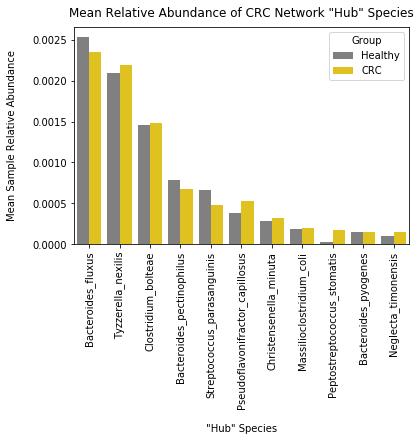

In [13]:
ax = sns.barplot(data=meanTempDF, x='Species',y='Mean Relative Abundance', hue='Group',palette=["grey", "gold"])
ax.set_xlabel('"Hub" Species',labelpad=15)
ax.set_ylabel('Mean Sample Relative Abundance', labelpad=15)
ax.set_title('Mean Relative Abundance of CRC Network "Hub" Species', pad=10)
plt.xticks(rotation=90)
newLeg = plt.legend(facecolor='white', title='Group')

#
tempLabelList = []
for i in plt.gca().get_xticklabels():
    tempLabelList.append(i)
newList = {}
for i in tempLabelList:
    newList[i] = (str(i).split(",")[2].split("'")[1])
    
[i.set_color(CRCnodeColor[newList[i]]) for i in plt.gca().get_xticklabels()]

legend_elements = [Line2D([0], [0],  color='#023eff',label='Cluster: 1'),
                   Line2D([0], [0], color='#ff7c00', label='Cluster: 2'),
                  Line2D([0], [0],  color='#1ac938', label='Cluster: 3'),
                  Line2D([0], [0],  color='#8b2be2', label='Cluster: 4'),
                  Line2D([0], [0], color='#e8000b', label='Cluster: 5')]

# Create the figure
plt.legend(handles=legend_elements, loc=4, facecolor='white', title='Hub Module Cluster',bbox_to_anchor=(1,0.5))
plt.gca().add_artist(newLeg)

#plt.savefig("/home/mark/Desktop/CRCvsHealthy/Images/CRCHub_MeanAbundance.pdf", bbox_inches='tight', dpi=300)
#plt.savefig("/home/mark/Desktop/CRCvsHealthy/Images/CRCHub_MeanAbundance.png", bbox_inches='tight', dpi=300)
plt.show()

In [14]:
MeantempDict = {'Species':[],'Mean Relative Abundance':[], 'Group':[]}
for i in HealthyHubSpeciesList:
    MeantempDict['Species'].append(i)
    MeantempDict['Mean Relative Abundance'].append(CRCallSpecies[i].dropna().mean())
    MeantempDict['Group'].append('CRC')
    
    MeantempDict['Species'].append(i)
    MeantempDict['Mean Relative Abundance'].append(HealthyallSpecies[i].dropna().mean())
    MeantempDict['Group'].append('Healthy')
    
meanTempDF = pd.DataFrame(data=MeantempDict)

In [15]:
meanTempDF.sort_values(by='Mean Relative Abundance', inplace=True, ascending=False)

NameError: name 'HealthynodeColor' is not defined

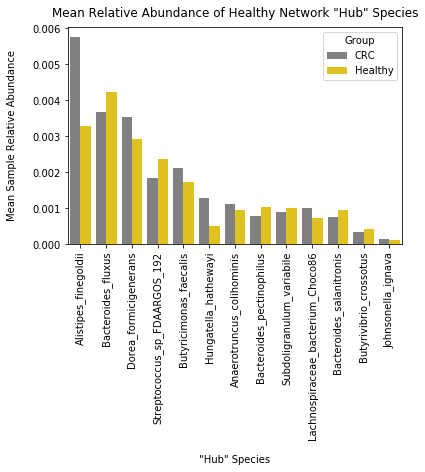

In [16]:
ax = sns.barplot(data=meanTempDF, x='Species',y='Mean Relative Abundance', hue='Group',palette=["grey", "gold"])
ax.set_xlabel('"Hub" Species',labelpad=15)
ax.set_ylabel('Mean Sample Relative Abundance', labelpad=15)
ax.set_title('Mean Relative Abundance of Healthy Network "Hub" Species', pad=10)
plt.xticks(rotation=90)
newLeg = plt.legend(facecolor='white', title='Group')

tempLabelList = []
for i in plt.gca().get_xticklabels():
    tempLabelList.append(i)
newList = {}
for i in tempLabelList:
    newList[i] = (str(i).split(",")[2].split("'")[1])
    
[i.set_color(HealthynodeColor[newList[i]]) for i in plt.gca().get_xticklabels()]

legend_elements = [Line2D([0], [0],  color='#023eff',label='Cluster: 1'),
                   Line2D([0], [0], color='#ff7c00', label='Cluster: 2'),
                  Line2D([0], [0],  color='#1ac938', label='Cluster: 3'),
                  Line2D([0], [0],  color='#8b2be2', label='Cluster: 4'),
                  Line2D([0], [0], color='#e8000b', label='Cluster: 5')]

# Create the figure
plt.legend(handles=legend_elements, loc=4, facecolor='white', title='Hub Module Cluster',bbox_to_anchor=(1,0.5))
plt.gca().add_artist(newLeg)
plt.show()

In [17]:
daSpecies3.loc[testList]

,Healthy_Median,Healthy_Distribution,CRC_Median,CRC_Distribution,Test,Test_Statistic,P_Value,Correction_Performed,Corrected_Pvalue,Reject
Species,,,,,,,,,,
Bacteroides_pectinophilus,12.519508,Not Normally Distributed,12.121900,Normally Distributed,Mann-Whitney U Test,8429.0,4.717109e-04,fdr_bh,1.344920e-03,True
Bacteroides_salanitronis,12.475048,Not Normally Distributed,11.881508,Normally Distributed,Mann-Whitney U Test,8023.0,6.412616e-03,fdr_bh,1.067461e-02,True
Peptostreptococcus_stomatis,-2.576004,Normally Distributed,10.290050,Not Normally Distributed,Mann-Whitney U Test,3145.0,6.634730e-11,fdr_bh,4.511617e-08,True
Streptococcus_sp_FDAARGOS_192,11.878218,Not Normally Distributed,11.259719,Not Normally Distributed,Mann-Whitney U Test,7735.0,2.930250e-02,fdr_bh,4.322278e-02,True
Butyrivibrio_crossotus,11.481938,Not Normally Distributed,11.015304,Normally Distributed,Mann-Whitney U Test,8186.0,2.403683e-03,fdr_bh,4.453690e-03,True


In [18]:
HHubtempDict = {'SampleName':[],'Species':[],'Relative Abundance':[], 'Group':[]}
for i in HealthyallSpecies.index:
    for y in HealthyHubSpeciesList:
        HHubtempDict['SampleName'].append(i)
        HHubtempDict['Species'].append(y)
        HHubtempDict['Relative Abundance'].append(HealthyallSpecies.at[i,y])
        HHubtempDict['Group'].append("Healthy")
        
for i in CRCallSpecies.index:
    for y in HealthyHubSpeciesList:
        HHubtempDict['SampleName'].append(i)
        HHubtempDict['Species'].append(y)
        HHubtempDict['Relative Abundance'].append(CRCallSpecies.at[i,y])
        HHubtempDict['Group'].append("CRC")
        
tempDF = pd.DataFrame(data=HHubtempDict)
tempDF2 = tempDF.set_index("SampleName").dropna()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

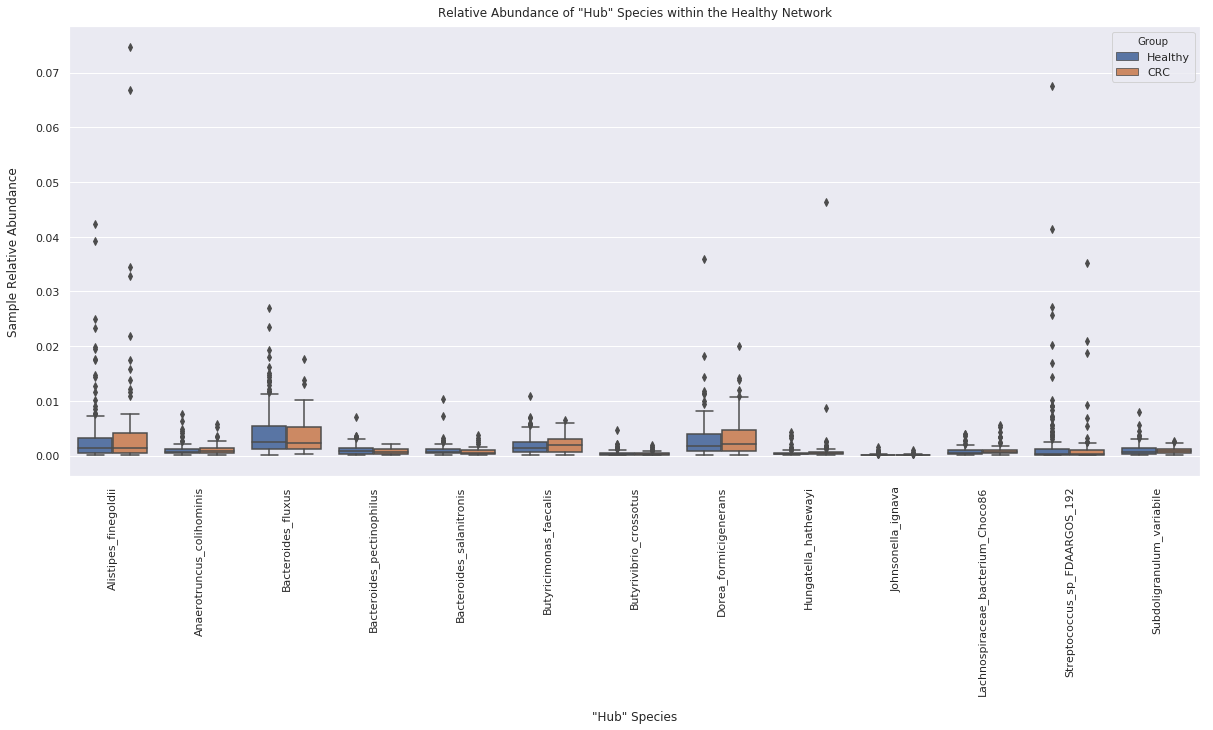

In [19]:
rcParams['figure.figsize'] = 20.27,8.27
sns.set(font_scale=1)

ax = sns.boxplot(data=tempDF2, x='Species', y='Relative Abundance', hue='Group')
ax.set_xlabel('"Hub" Species',labelpad=15)
ax.set_ylabel('Sample Relative Abundance', labelpad=15)
ax.set_title('Relative Abundance of "Hub" Species within the Healthy Network', pad=10)
plt.xticks(rotation=90)

In [20]:
CHubtempDict = {'SampleName':[],'Species':[],'Relative Abundance':[], 'Group':[]}
for i in HealthyallSpecies.index:
    for y in CRCHubSpeciesList:
        CHubtempDict['SampleName'].append(i)
        CHubtempDict['Species'].append(y)
        CHubtempDict['Relative Abundance'].append(HealthyallSpecies.at[i,y])
        CHubtempDict['Group'].append("Healthy")
        
for i in CRCallSpecies.index:
    for y in CRCHubSpeciesList:
        CHubtempDict['SampleName'].append(i)
        CHubtempDict['Species'].append(y)
        CHubtempDict['Relative Abundance'].append(CRCallSpecies.at[i,y])
        CHubtempDict['Group'].append("CRC")
        
CtempDF = pd.DataFrame(data=CHubtempDict)
CtempDF2 = tempDF.set_index("SampleName").dropna()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

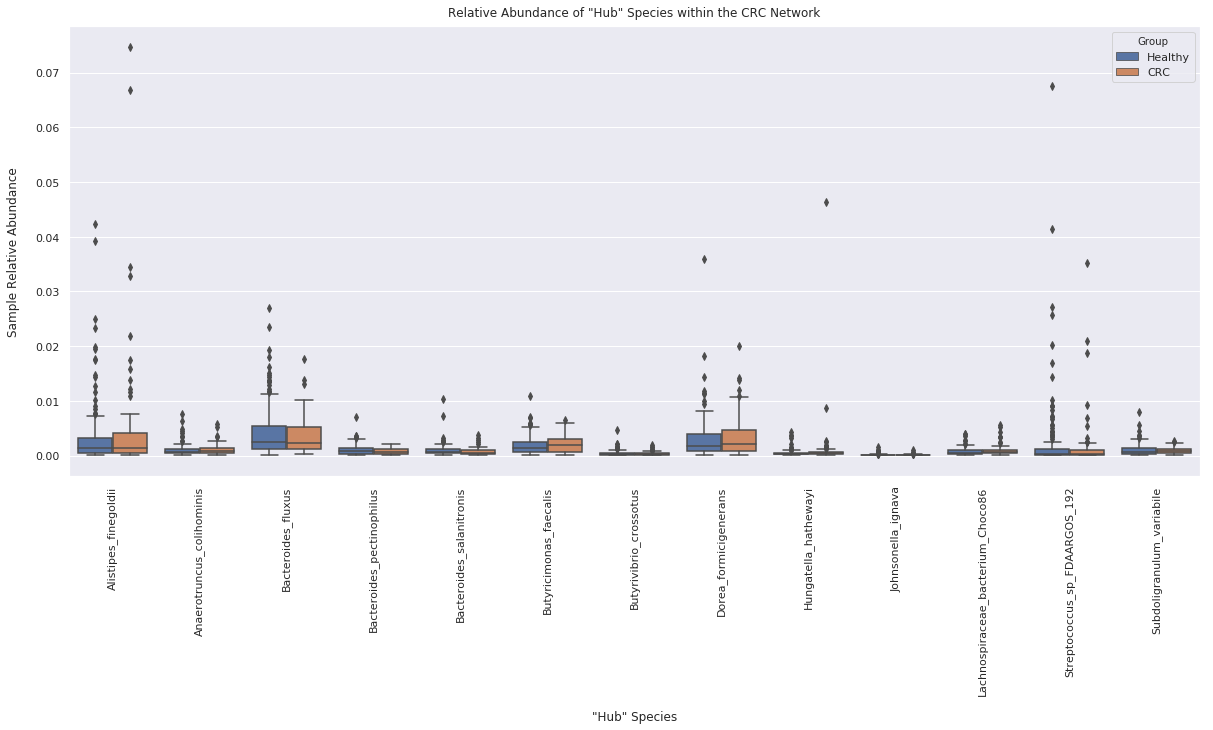

In [21]:
rcParams['figure.figsize'] = 20.27,8.27
ax = sns.boxplot(data=CtempDF2, x='Species', y='Relative Abundance', hue='Group')
ax.set_xlabel('"Hub" Species',labelpad=15)
ax.set_ylabel('Sample Relative Abundance', labelpad=15)
ax.set_title('Relative Abundance of "Hub" Species within the CRC Network', pad=10)
plt.xticks(rotation=90)